In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import calculus_library as callib
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import linear_algebra_library as linlib
import autograd.numpy as np
import time

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

# run the visualizer for our chosen input function, initial point, and step length alpha
static_plotter = optlib.static_plotter.Visualizer();
anime_plotter = optlib.animation_plotter.Visualizer();

%load_ext autoreload
%autoreload 2

# Algorithms

## Gradient descent

In [2]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import value_and_grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha,max_its,w):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g(w))  
    return weight_history,cost_history

## Newton's method

In [19]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import value_and_grad 
from autograd import hessian

# newtons method function - inputs: g (input function), max_its (maximum number of iterations), w (initialization)
def newtons_method(g,max_its,w,**kwargs):
    # compute the gradient / hessian functions of our input function -
    # note these are themselves functions.  In particular the gradient - 
    # - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)
    hess = hessian(g)
    
    # set numericxal stability parameter / regularization parameter
    beta = 10**(-7)
    if 'beta' in kwargs:
        beta = kwargs['beta']

    # run the newtons method loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)

        # evaluate the hessian
        hess_eval = hess(w)

        # reshape for numpy linalg functionality
        hess_eval.shape = (int((np.size(hess_eval))**(0.5)),int((np.size(hess_eval))**(0.5)))

        # solve second order system system for weight update
        w = w - np.dot(np.linalg.pinv(hess_eval + beta*np.eye(np.size(w))),grad_eval)

    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g(w))  
    return weight_history,cost_history

## Random local search

In [124]:
# random local search function
def random_local_search(g,alpha_choice,max_its,w,num_samples):
    # run random local search
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
            
        # record weights and cost evaluation
        weight_history.append(w)
        cost_history.append(g(w))
        
        # construct set of random unit directions
        directions = np.random.randn(num_samples,np.size(w))
        norms = np.sqrt(np.sum(directions*directions,axis = 1))[:,np.newaxis]
        directions = directions/norms   
        
        ### pick best descent direction
        # compute all new candidate points
        w_candidates = w + alpha*directions
        
        # evaluate all candidates
        evals = np.array([g(w_val) for w_val in w_candidates])

        # if we find a real descent direction take the step in its direction
        ind = np.argmin(evals)
        if g(w_candidates[ind]) < g(w):
            # pluck out best descent direction
            d = directions[ind,:]
        
            # take step
            w = w + alpha*d
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

## Zero order coordinate descent

In [131]:
# zero order coordinate descent
def zero_order_coordinate_descent(g,alpha_choice,max_its,w):
    # run random local search
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
            
        # record weights and cost evaluation
        weight_history.append(w)
        cost_history.append(g(w))
        
        # construct set of all coordinate directions
        directions_plus = np.eye(np.size(w),np.size(w))
        directions_minus = - np.eye(np.size(w),np.size(w))
        directions = np.concatenate((directions_plus,directions_minus),axis=0)
        
        ### pick best descent direction
        # compute all new candidate points
        w_candidates = w + alpha*directions
        
        # evaluate all candidates
        evals = np.array([g(w_val) for w_val in w_candidates])

        # if we find a real descent direction take the step in its direction
        ind = np.argmin(evals)
        if g(w_candidates[ind]) < g(w):
            # pluck out best descent direction
            d = directions[ind,:]
        
            # take step
            w = w + alpha*d
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

# Static images - zero order coordinate search

<IPython.core.display.Javascript object>


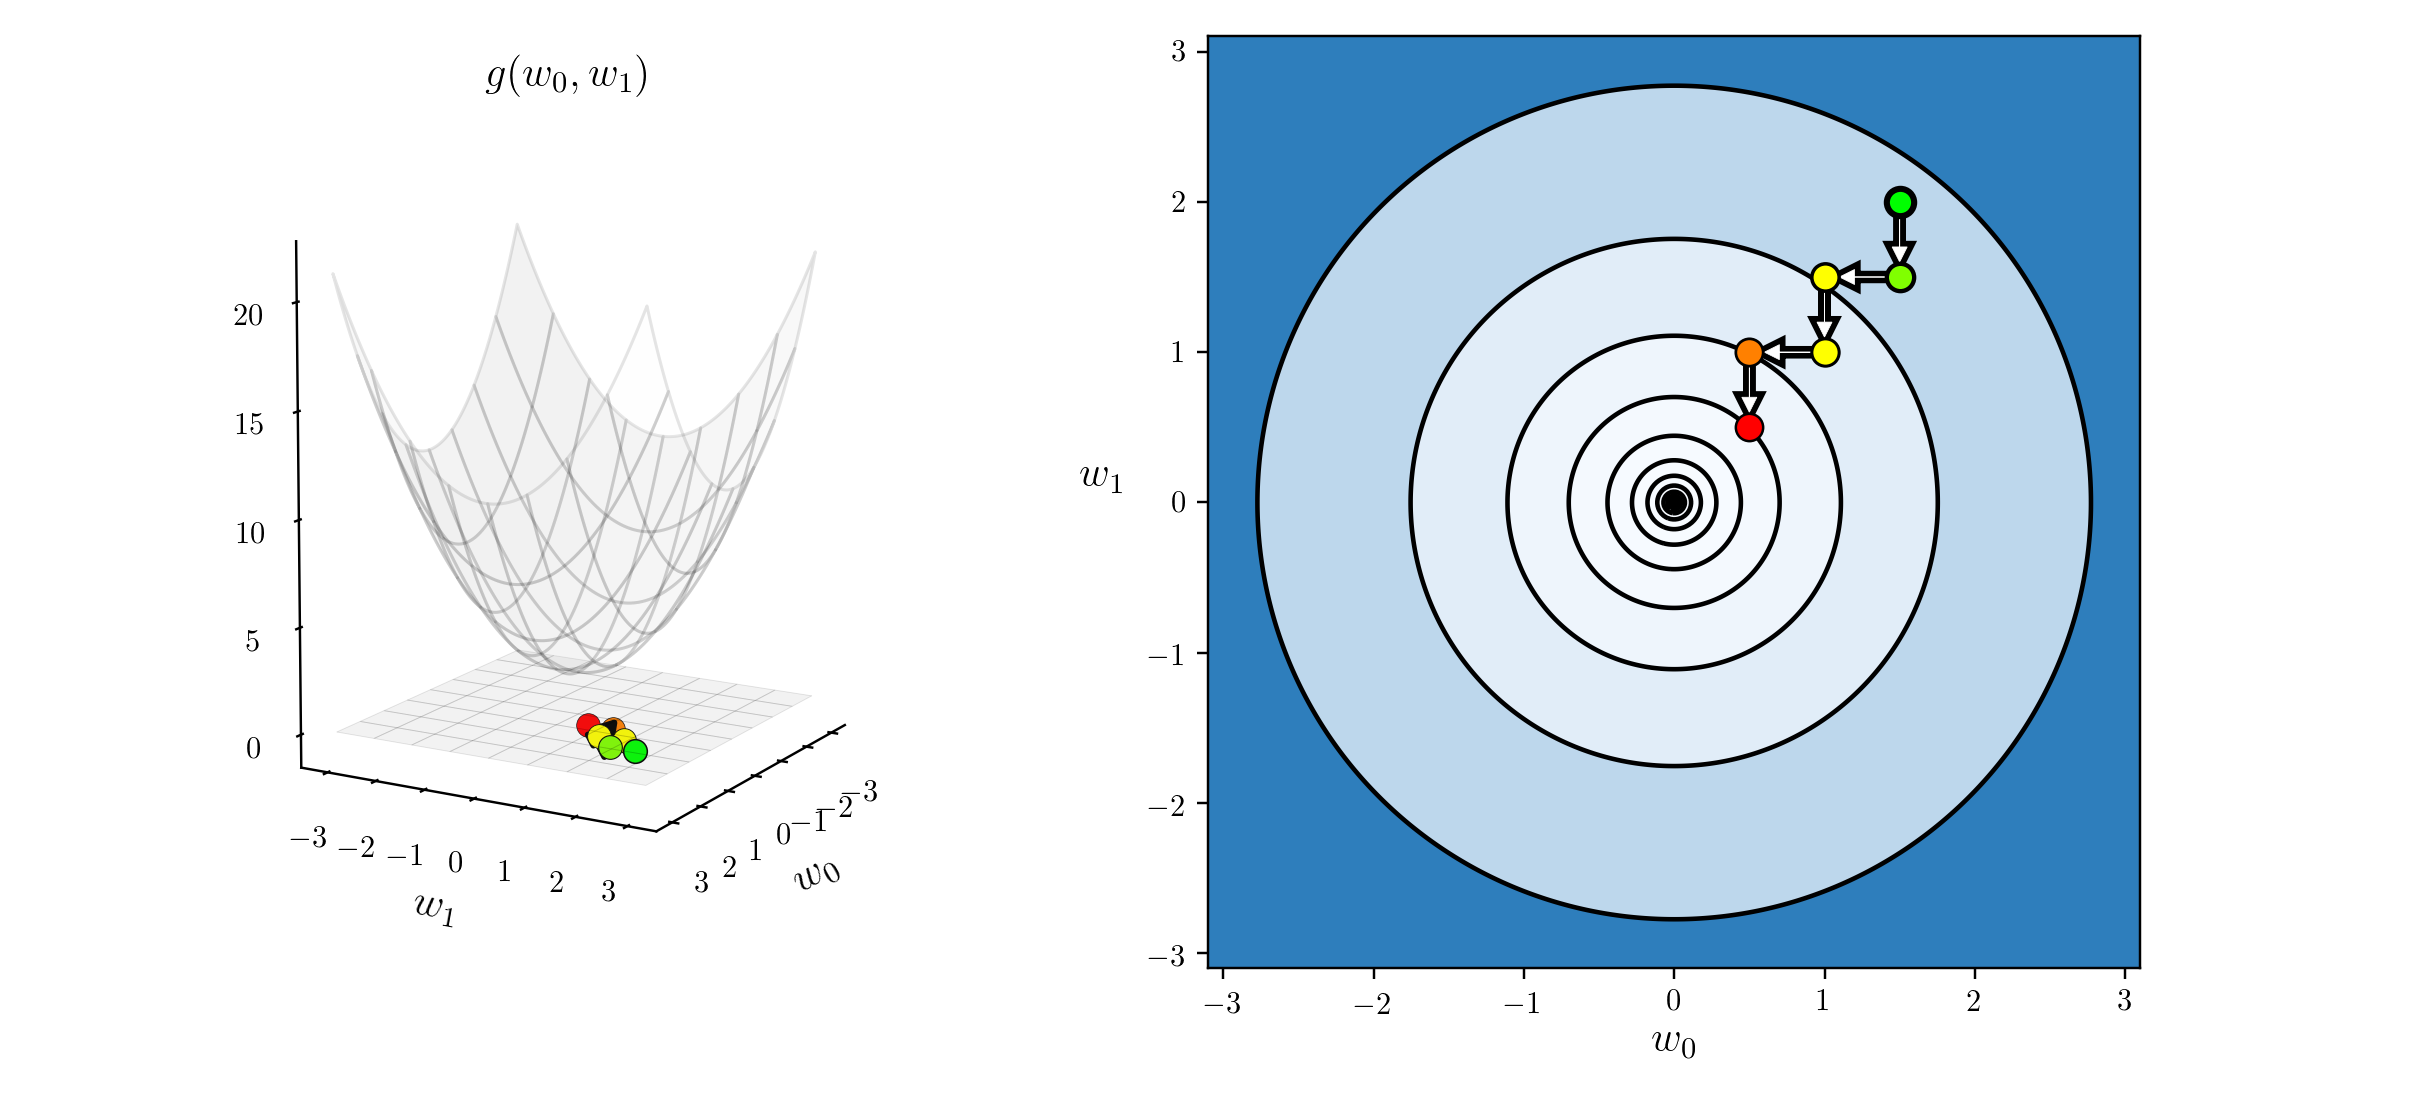

In [132]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.dot(w.T,w) + 2

# run gradient descent 
alpha_choice = 0.5; w = np.array([1.5,2]); max_its = 5;
weight_history,cost_history = zero_order_coordinate_descent(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_surface_contour_plot(g,weight_history,view = [10,30])

# Static images - random local search

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)


<IPython.core.display.Javascript object>


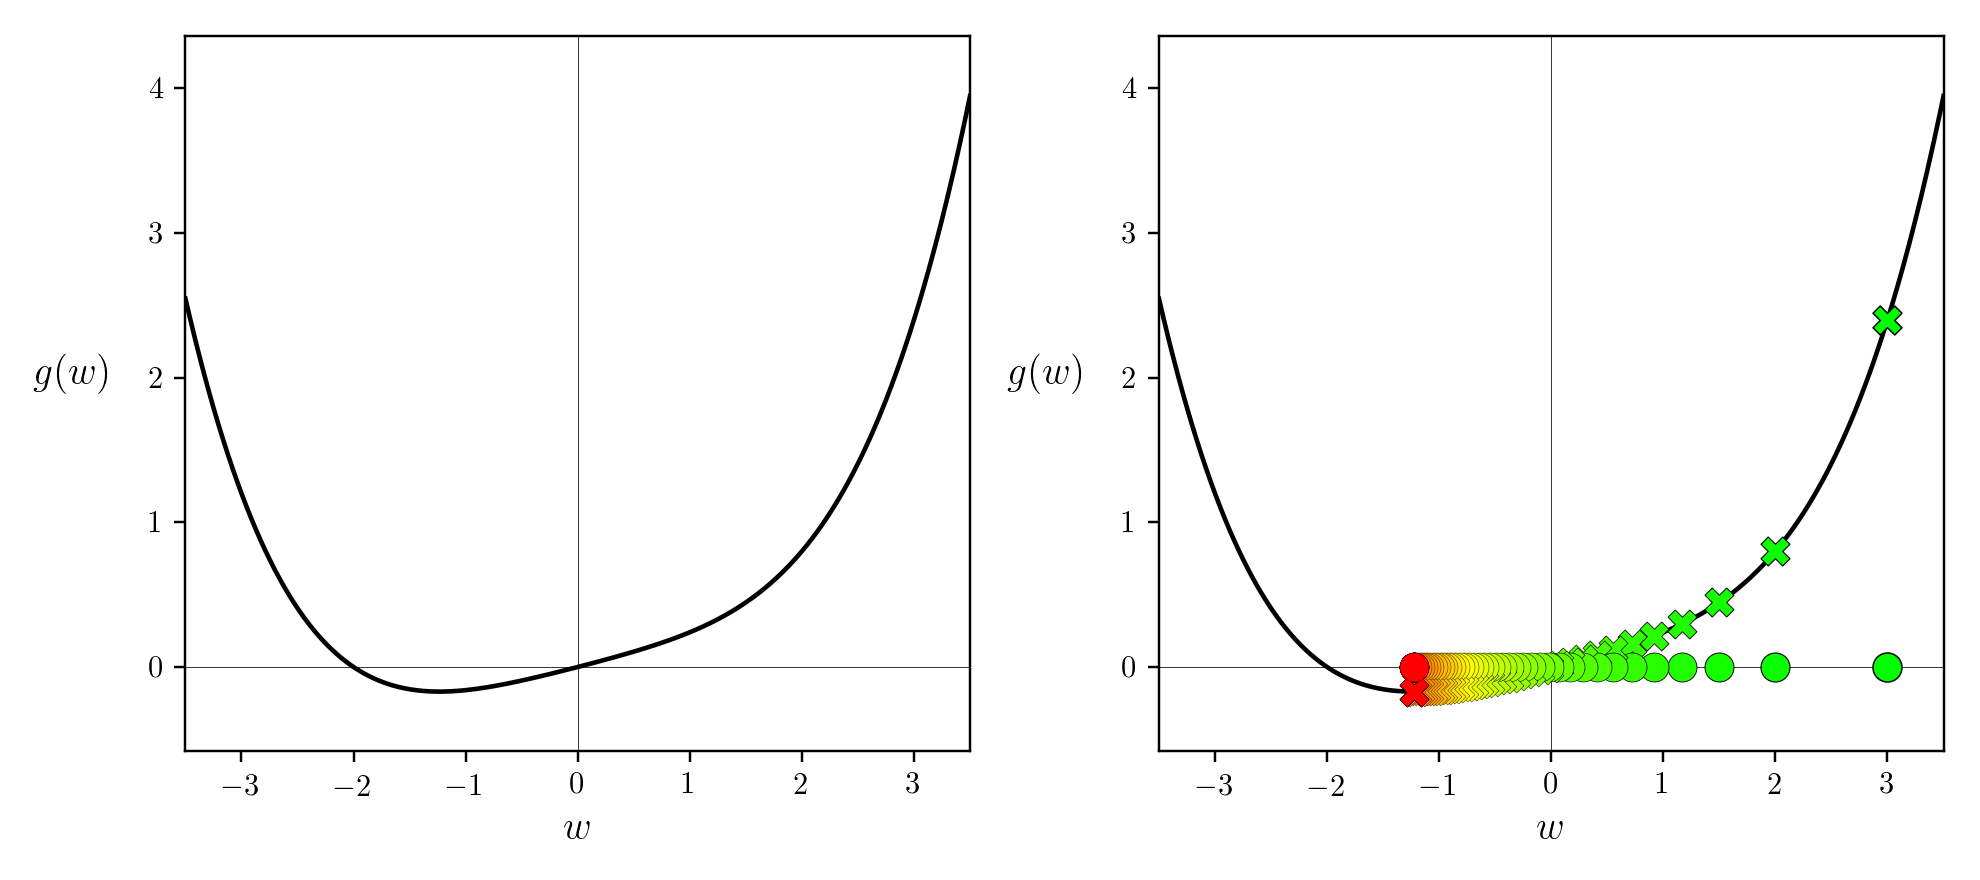

In [125]:
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)
alpha_choice = 'diminishing'; w = 3.0; num_samples = 50; max_its = 50;
weight_history,cost_history = random_local_search(g,alpha_choice,max_its,w,num_samples)

# make static plot showcasing each step of this run
static_plotter.single_input_plot(g,[weight_history],[cost_history],wmin = -3.5,wmax = 3.5)

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)


<IPython.core.display.Javascript object>


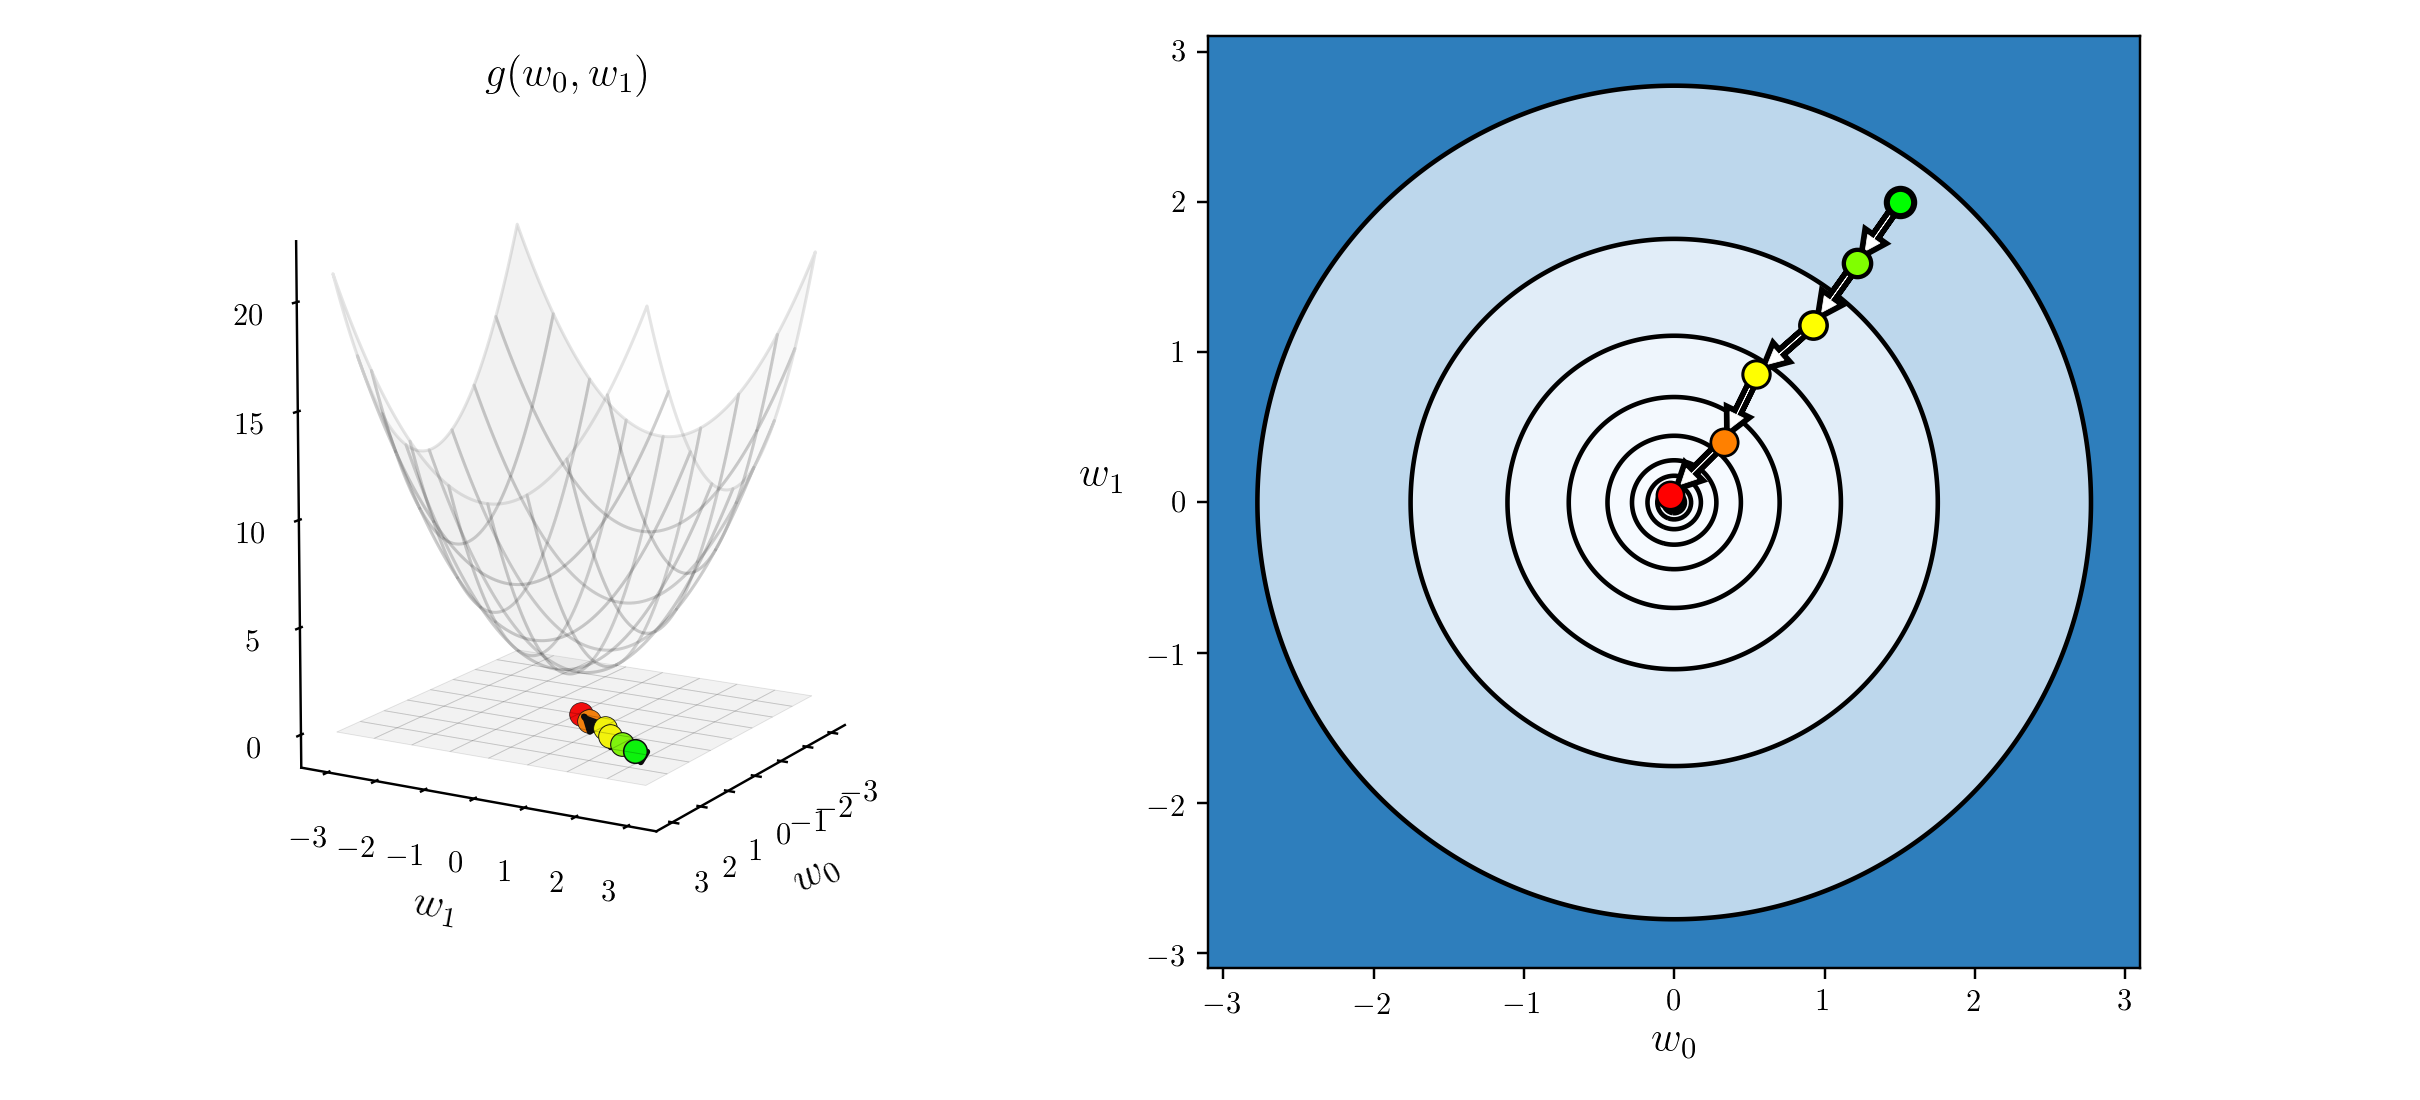

In [126]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.dot(w.T,w) + 2

# run gradient descent 
alpha_choice = 0.5; w = np.array([1.5,2]); num_samples = 20; max_its = 5;
weight_history,cost_history = random_local_search(g,alpha_choice,max_its,w,num_samples)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_surface_contour_plot(g,weight_history,view = [10,30])

# Static images - zero order coordinate descent

# Static images - gradient descent

<IPython.core.display.Javascript object>


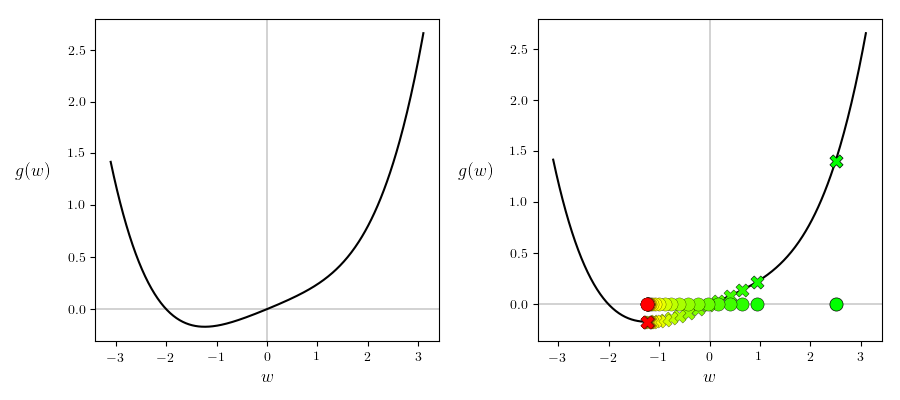

In [3]:
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)

# run gradient descent 
w = 2.5; alpha = 1; max_its = 25;
weight_history,cost_history = gradient_descent(g,alpha,max_its,w)

# make static plot showcasing each step of this run
static_plotter.single_input_plot(g,[weight_history],[cost_history])

<IPython.core.display.Javascript object>


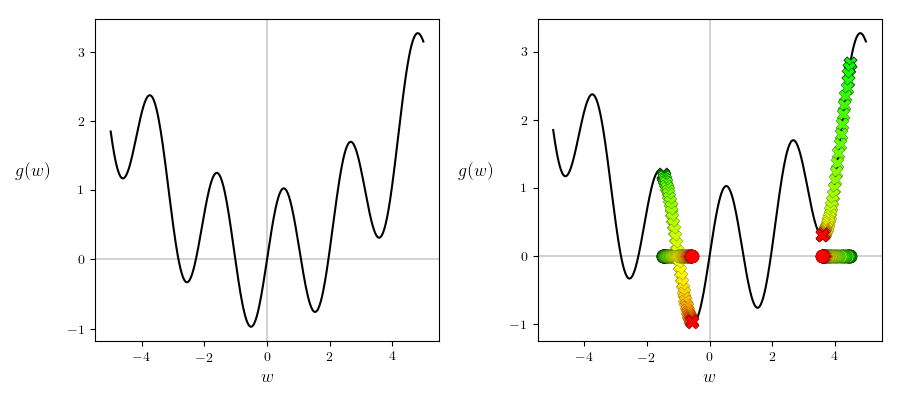

In [4]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.sin(3*w) + 0.1*w**2

# run gradient descent - run 1
w = 4.5; alpha = 0.01; max_its = 50;
weight_history_1,cost_history_1 = gradient_descent(g,alpha,max_its,w)

# run gradient descent - run 2
w = -1.5; alpha = 0.01; max_its = 50;
weight_history_2,cost_history_2 = gradient_descent(g,alpha,max_its,w)

# plot resulting runs
static_plotter.single_input_plot(g,[weight_history_1,weight_history_2],[cost_history_1,cost_history_2],wmin = -5,wmax = 5)

# Animated images - gradient descent / newtons method


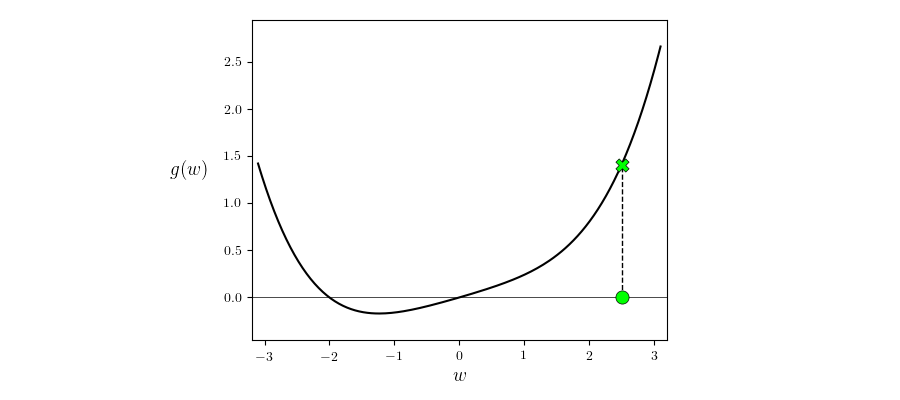
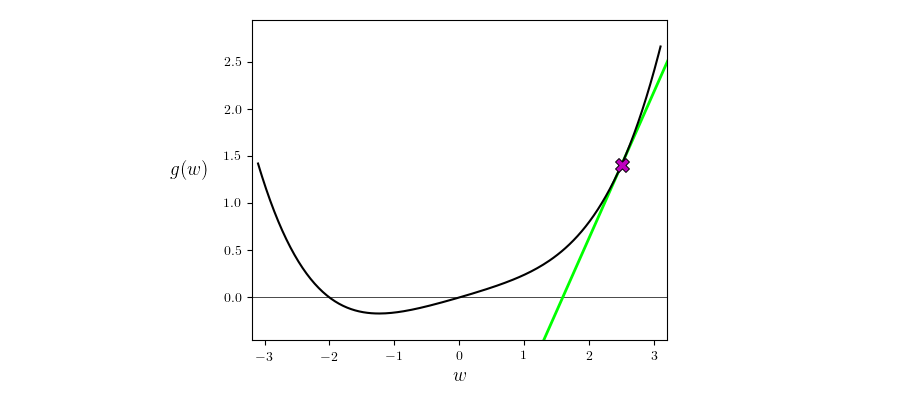
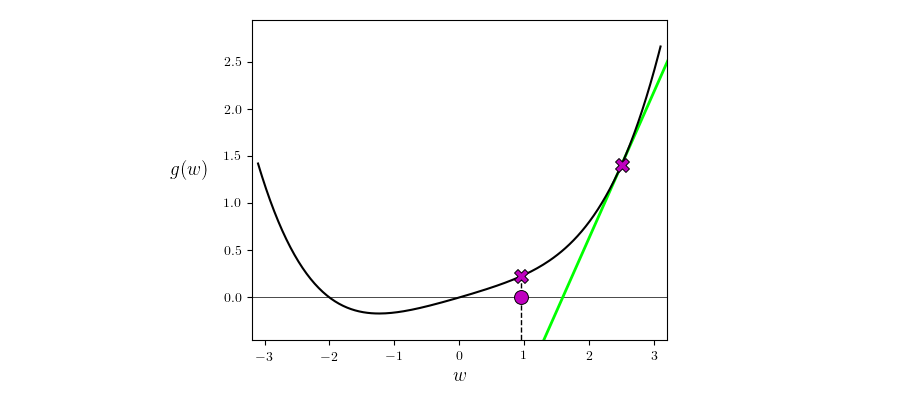
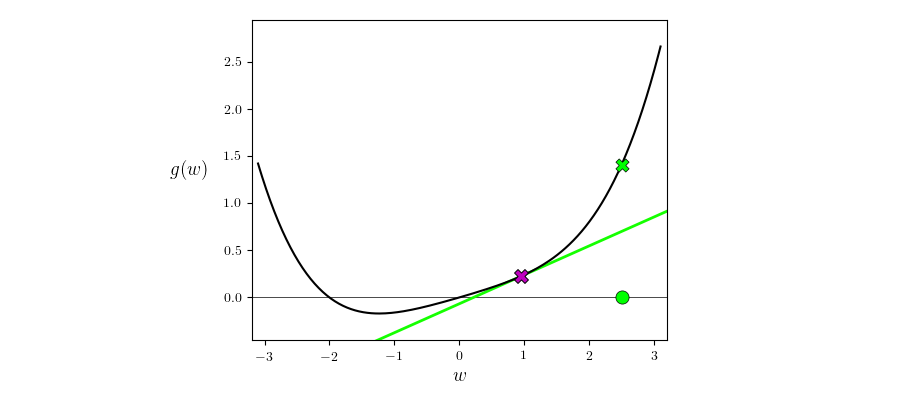
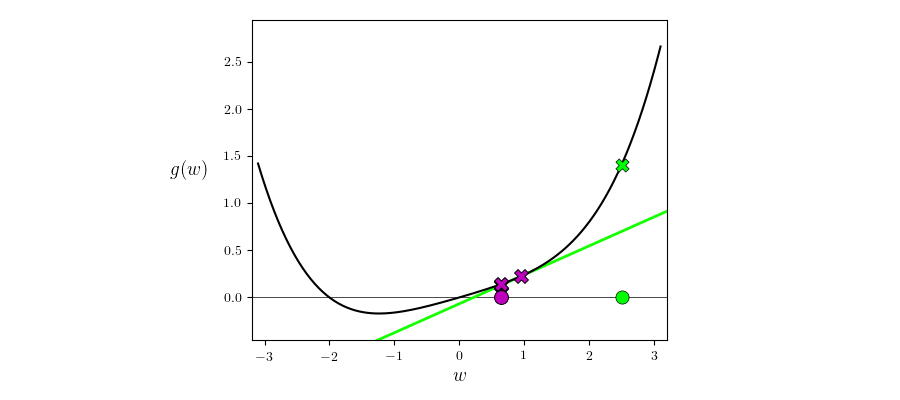
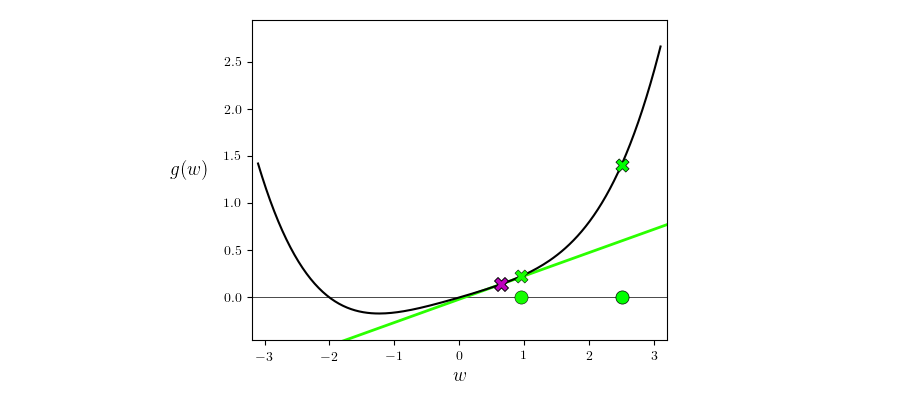
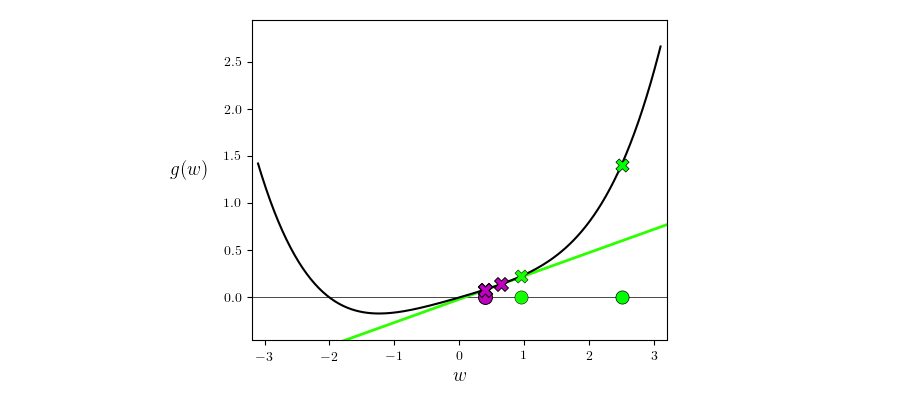
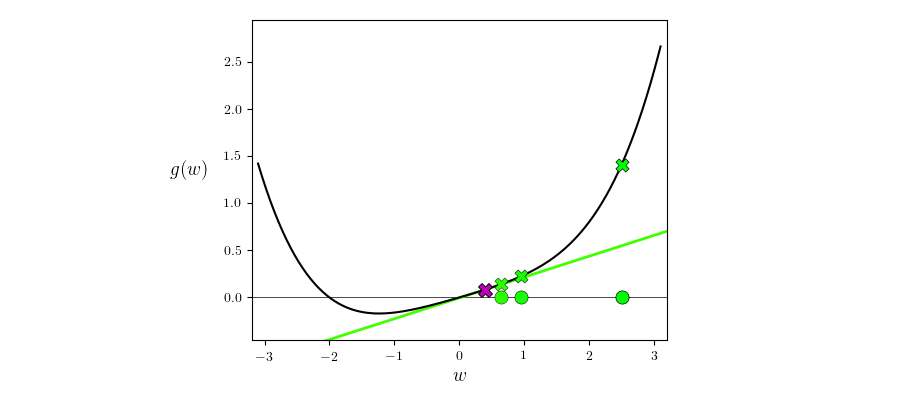
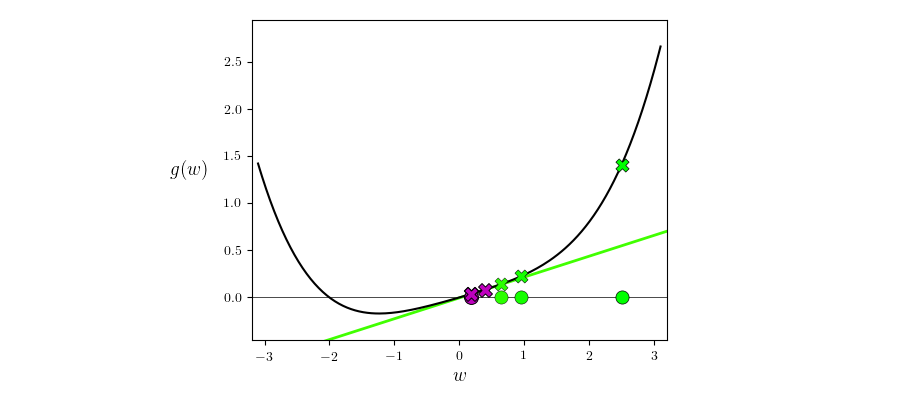
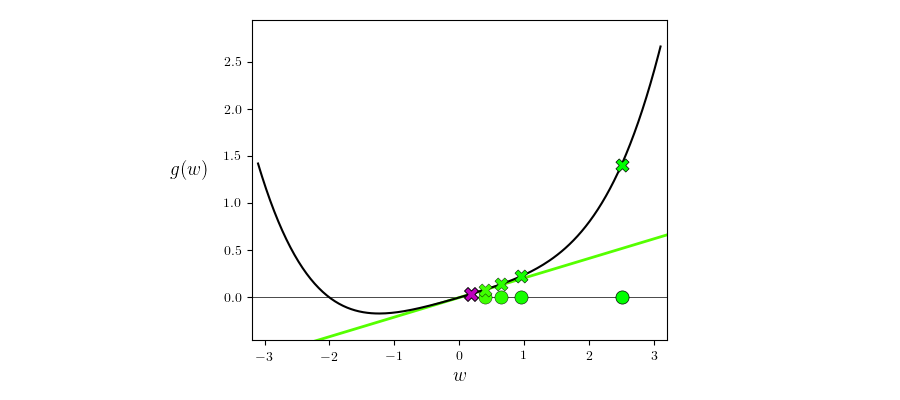
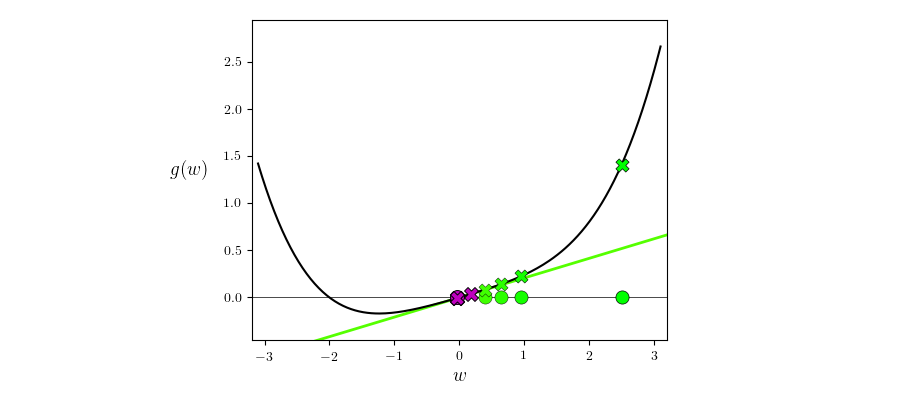
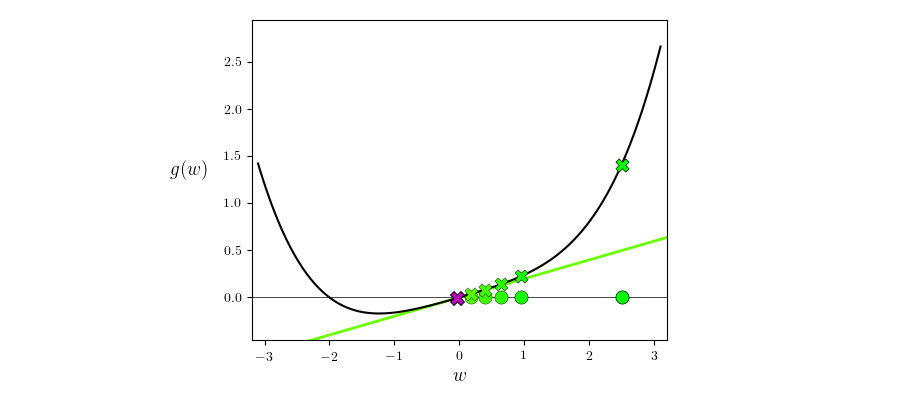
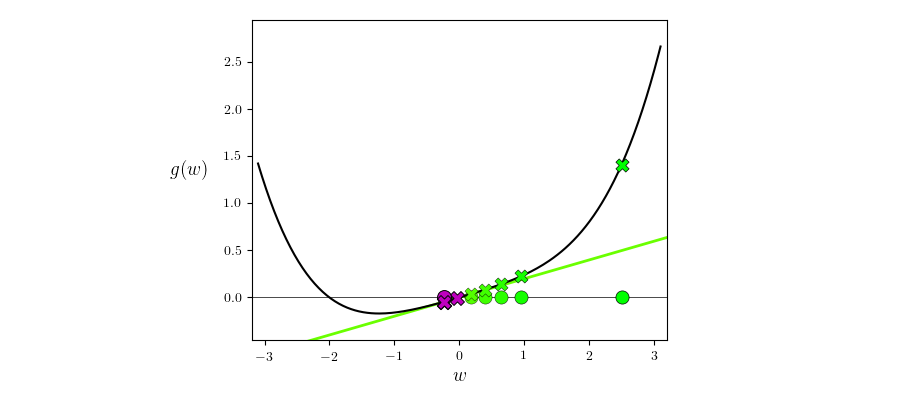
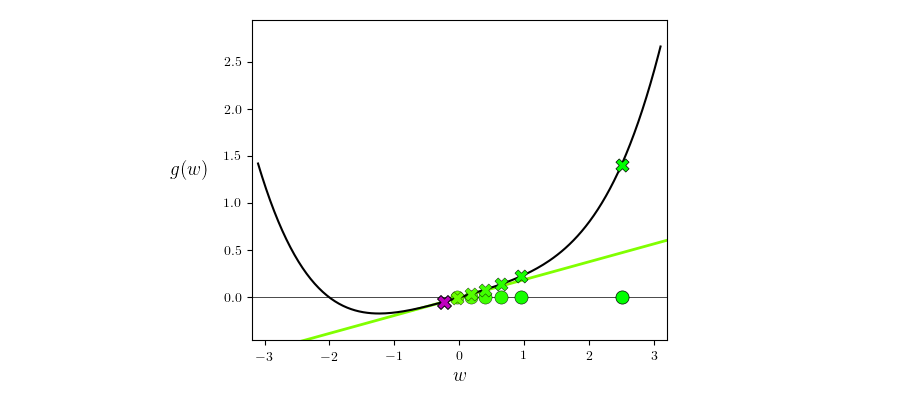
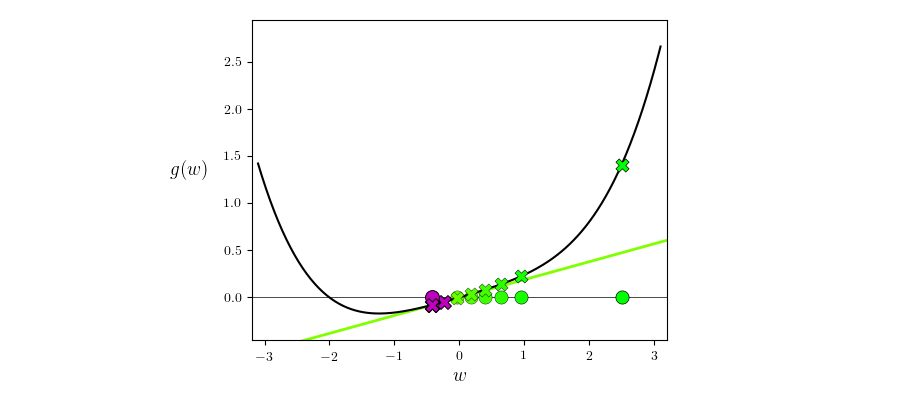
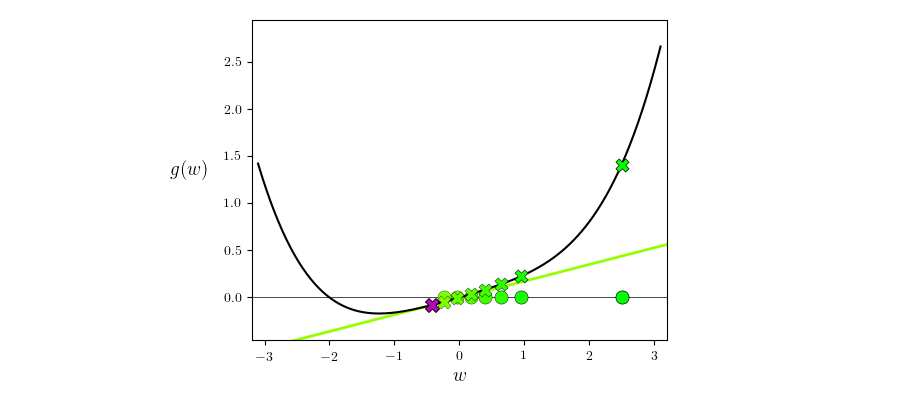
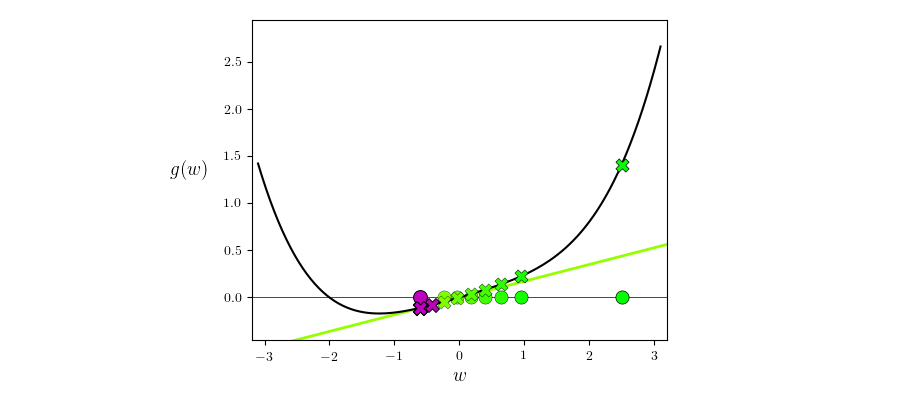
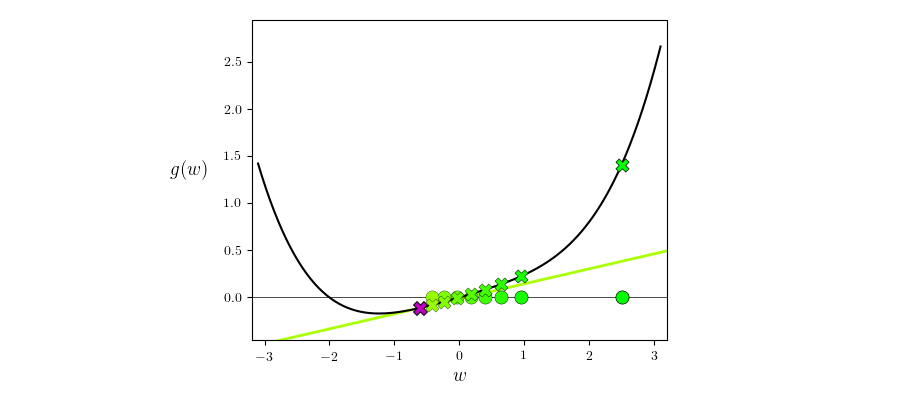
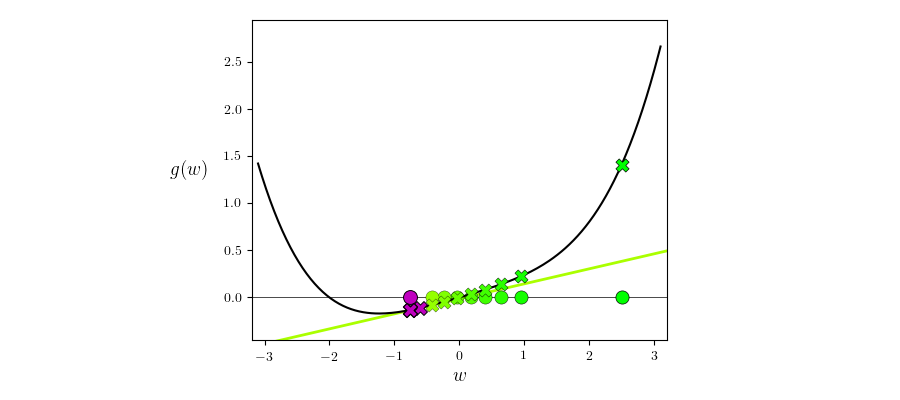
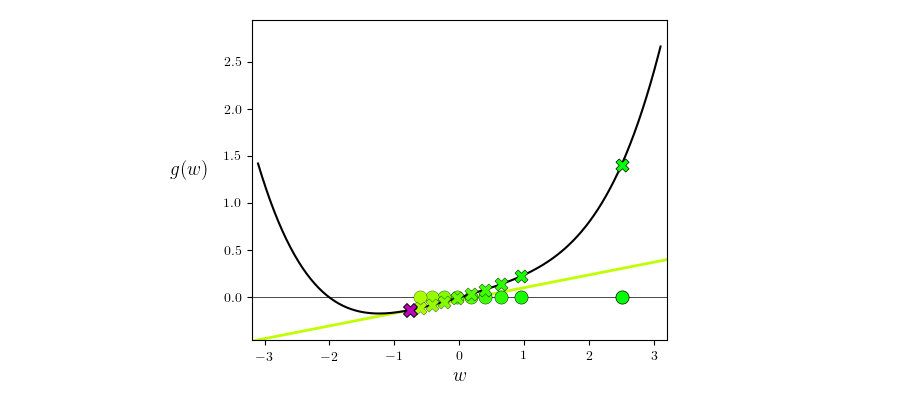
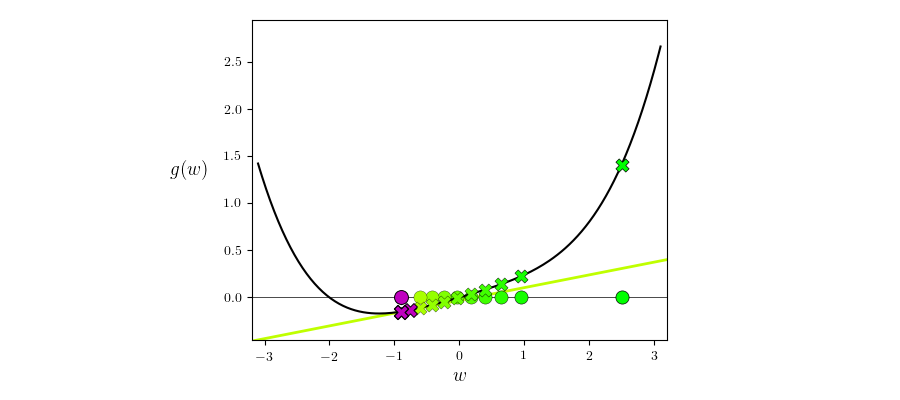
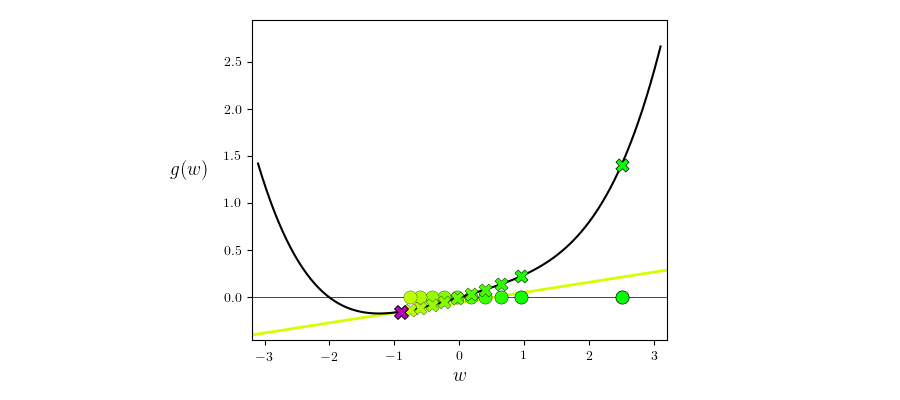
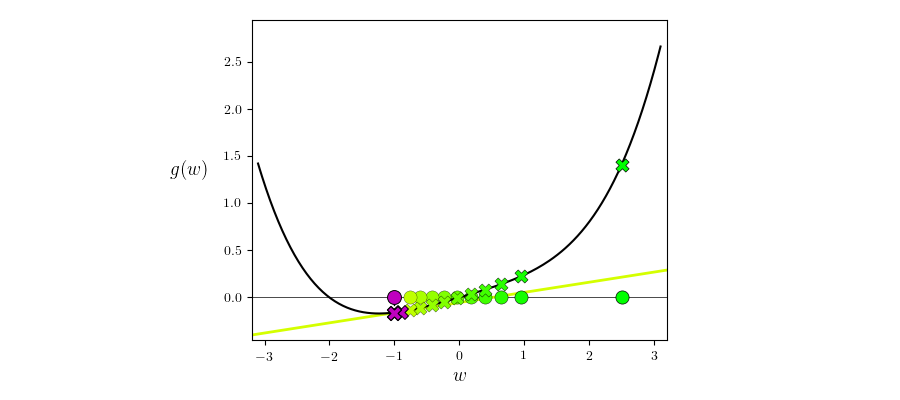
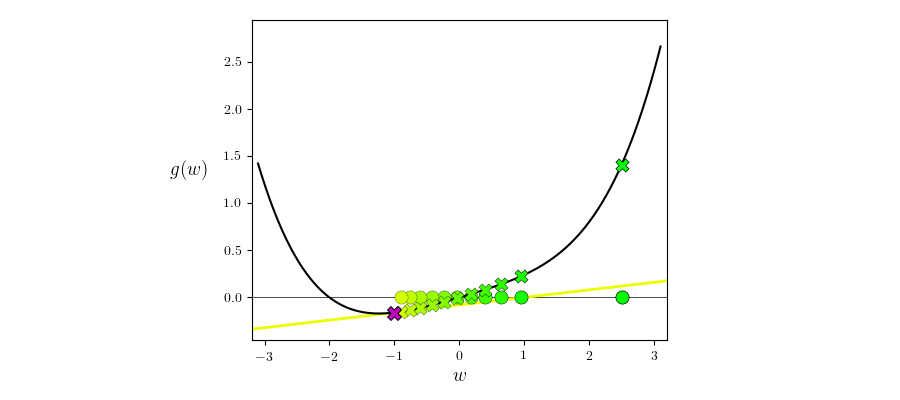
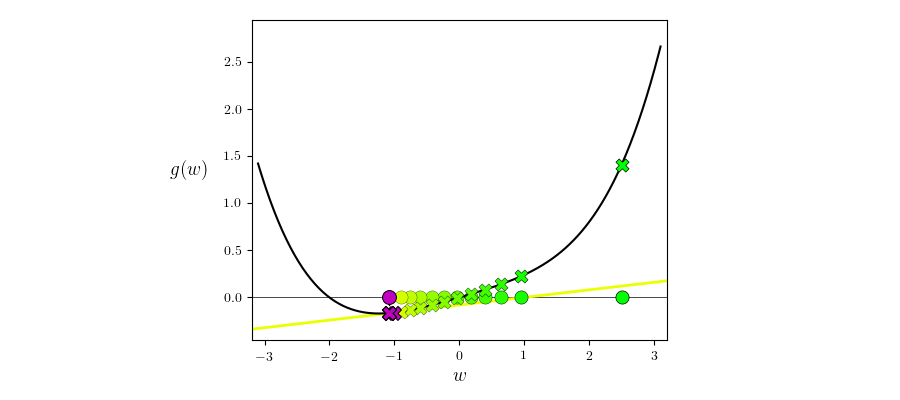
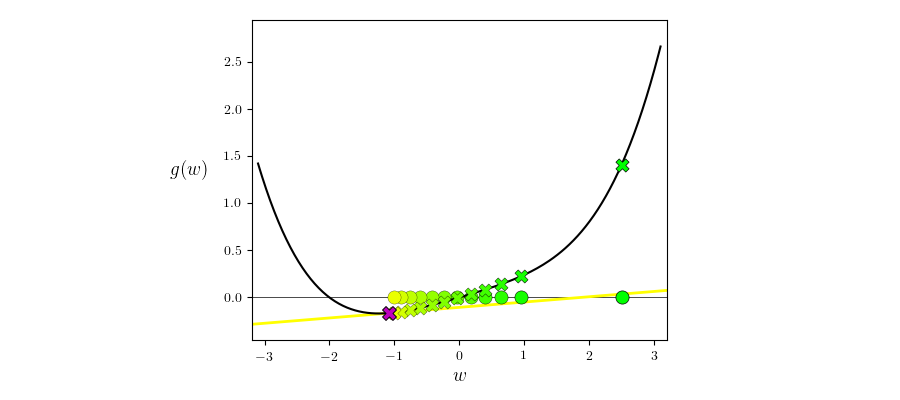
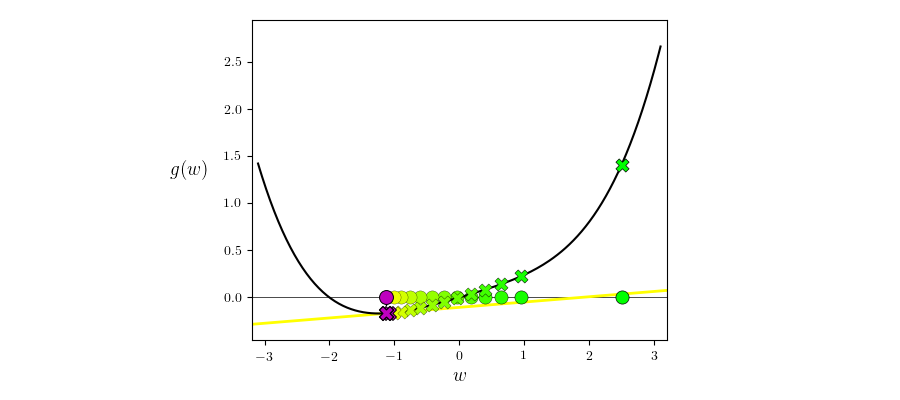
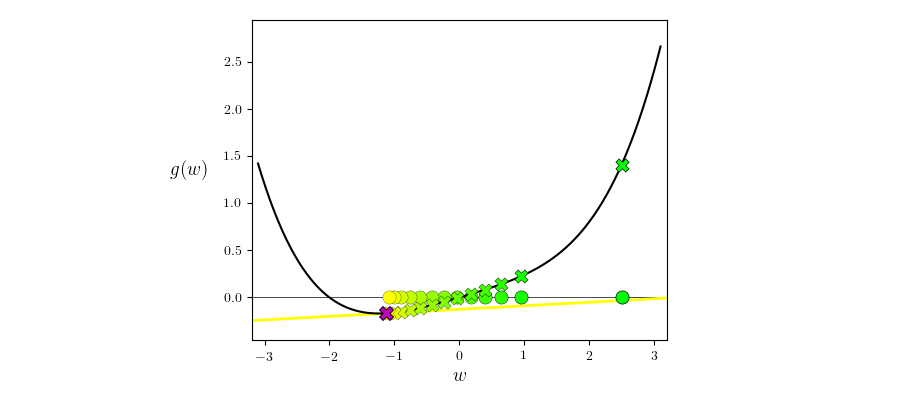
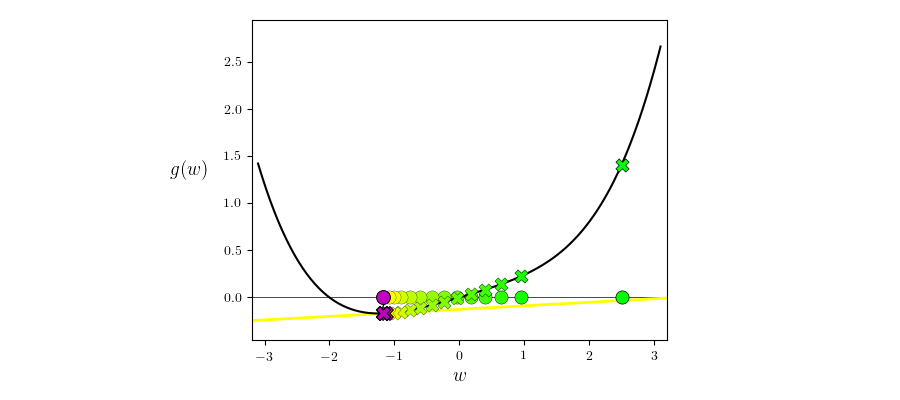
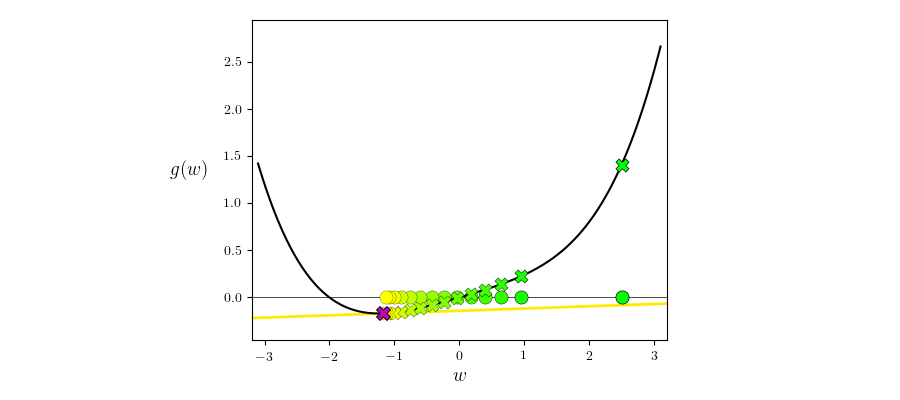
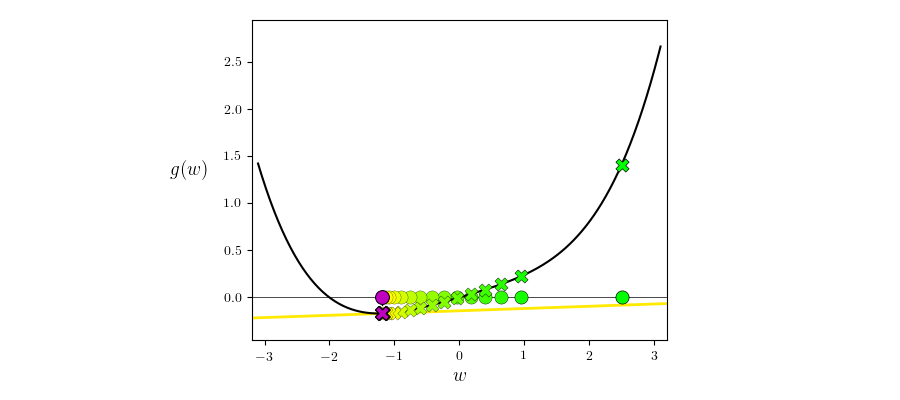
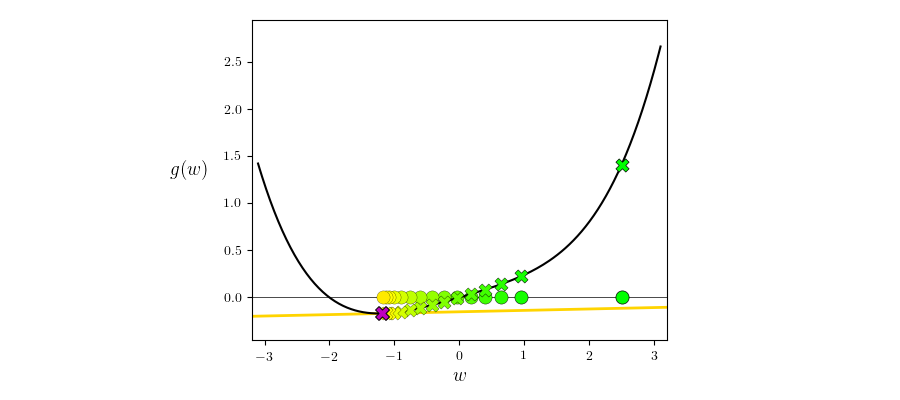
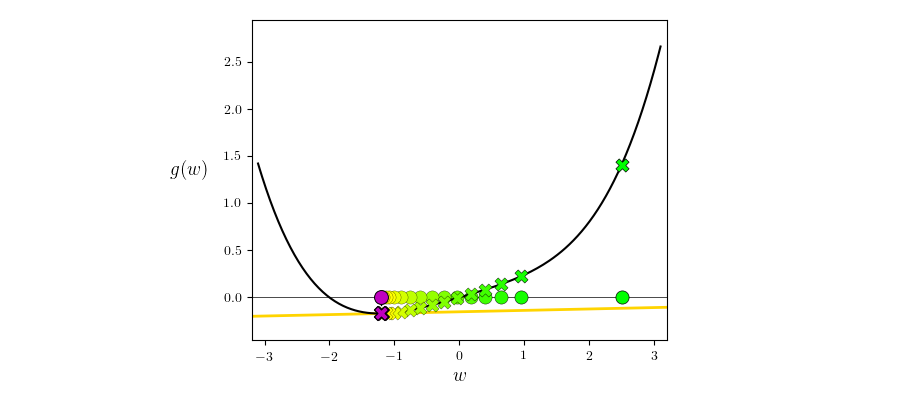
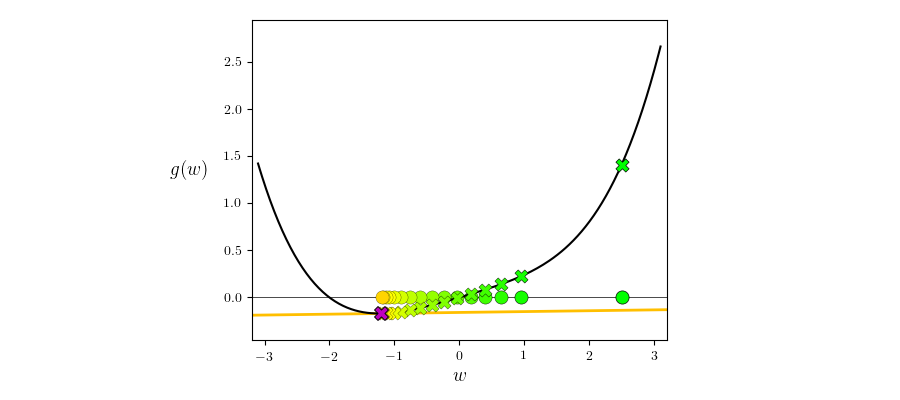
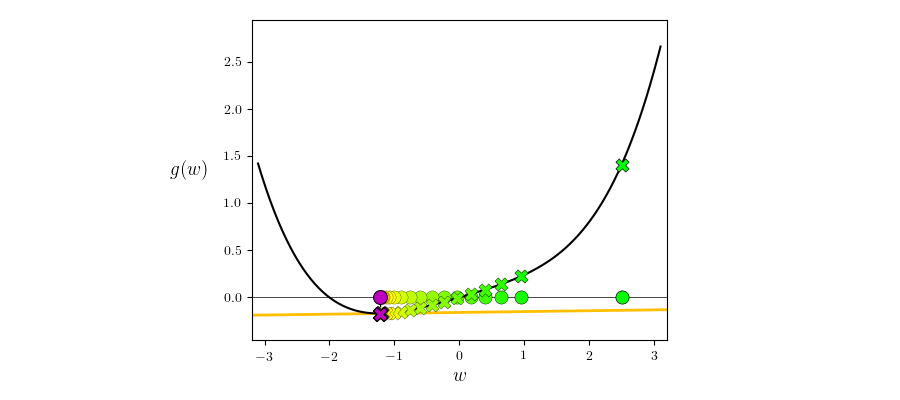
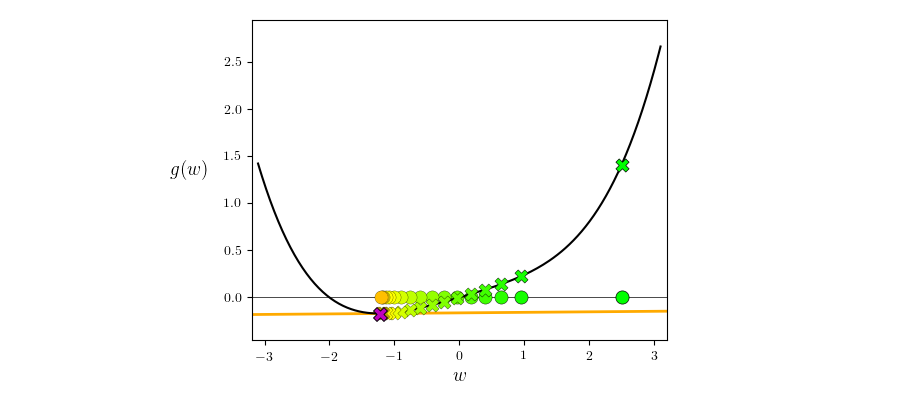
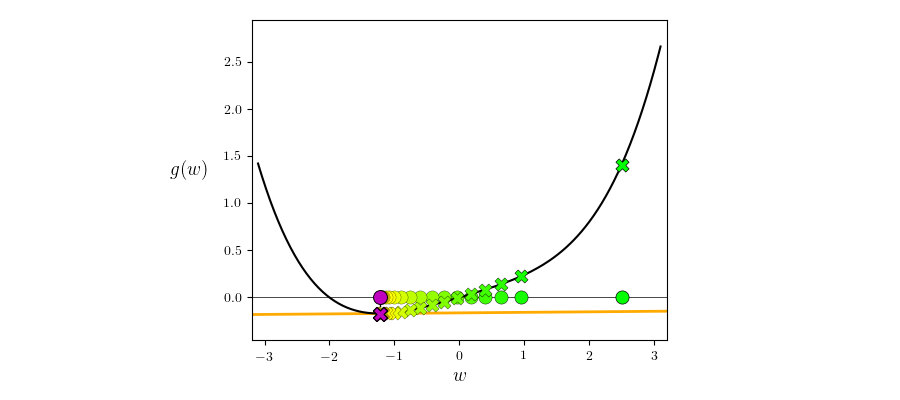
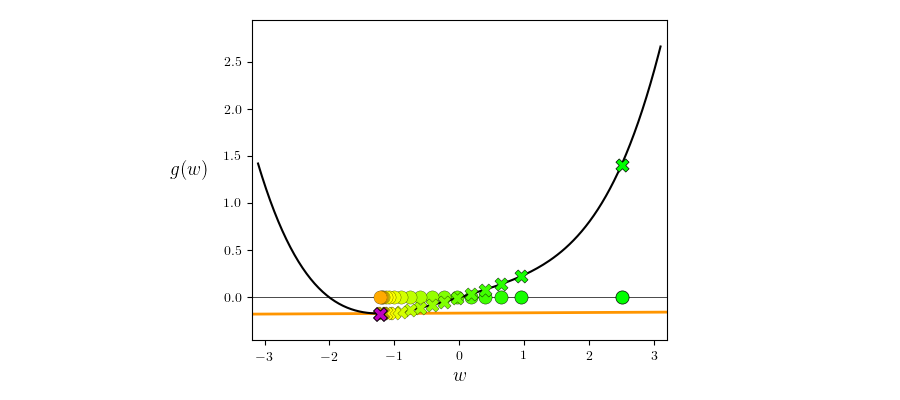
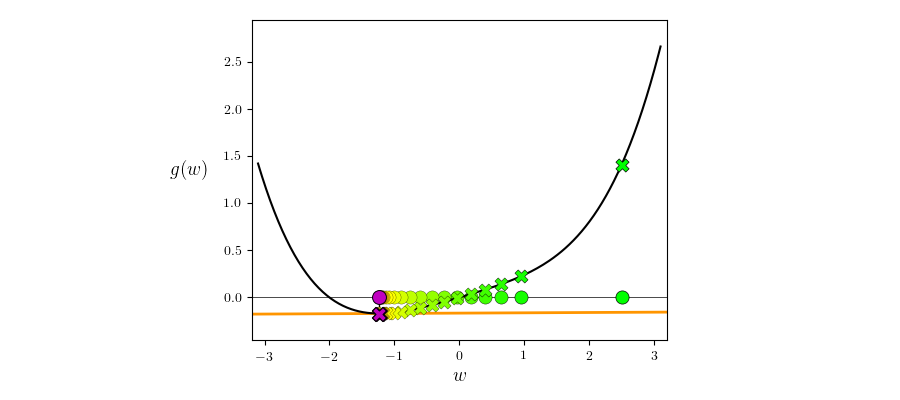
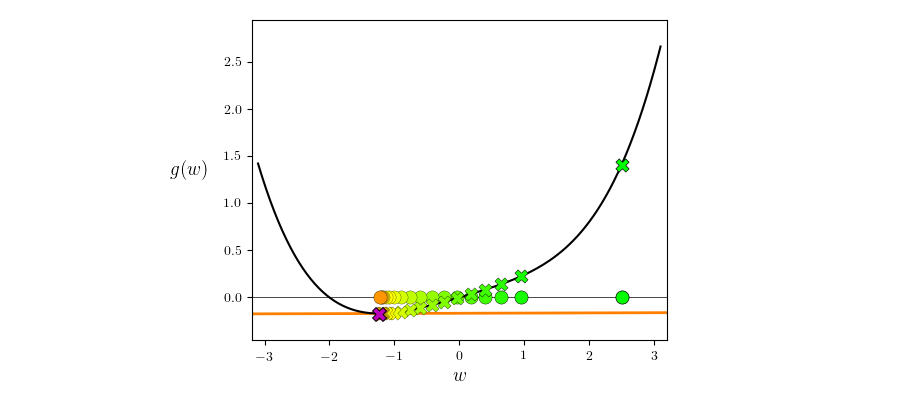
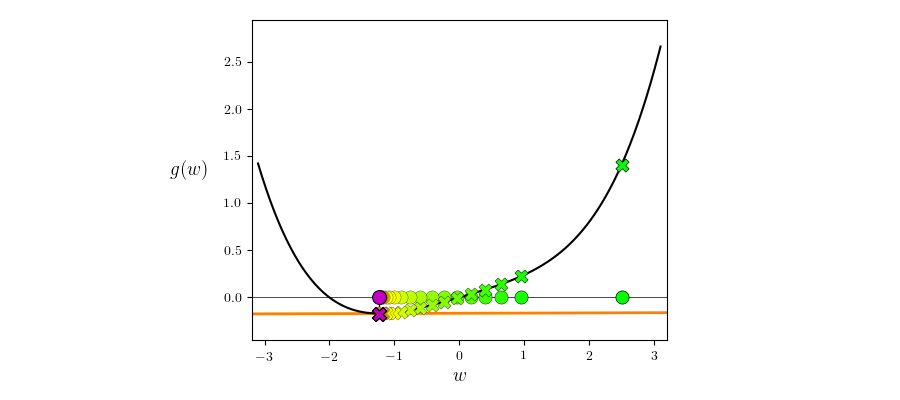
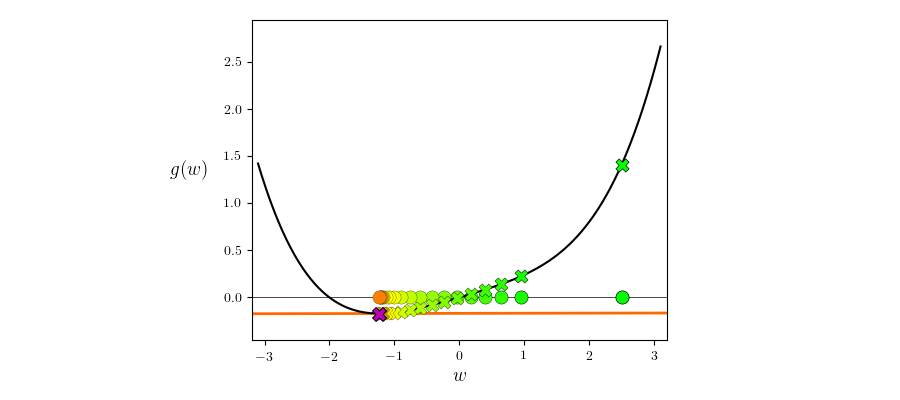
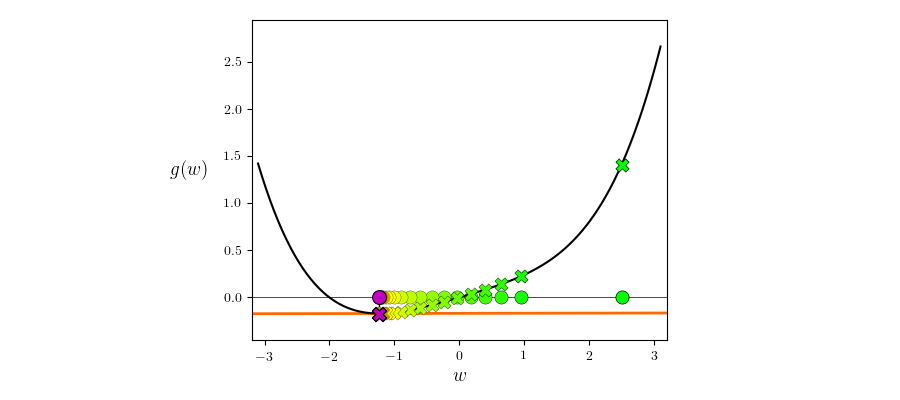
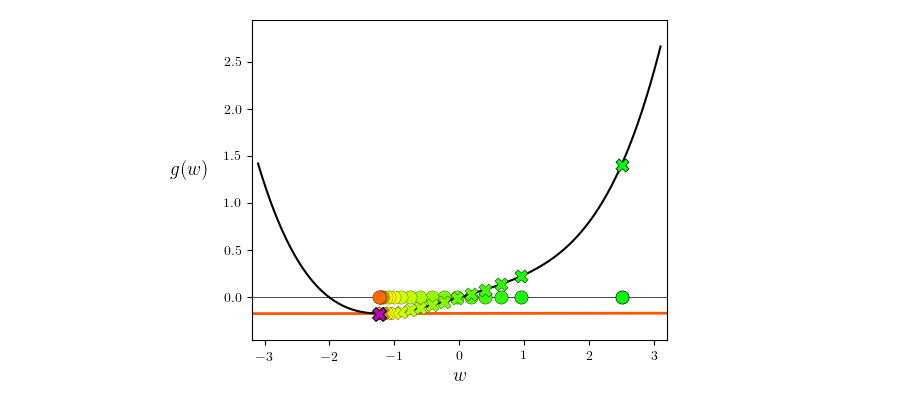
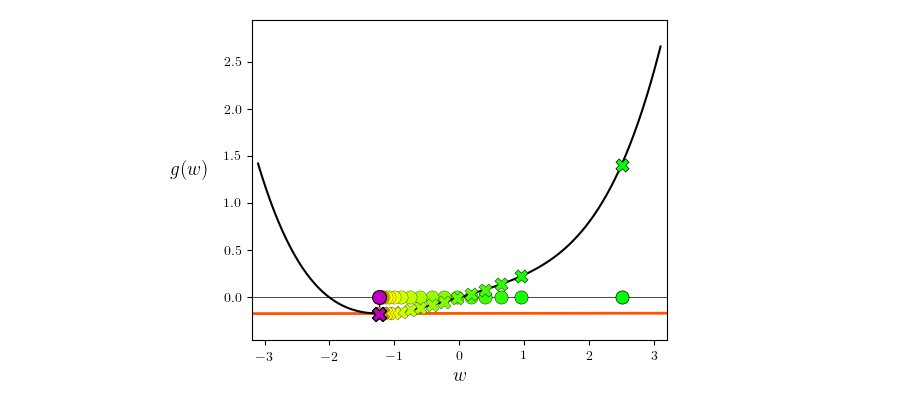
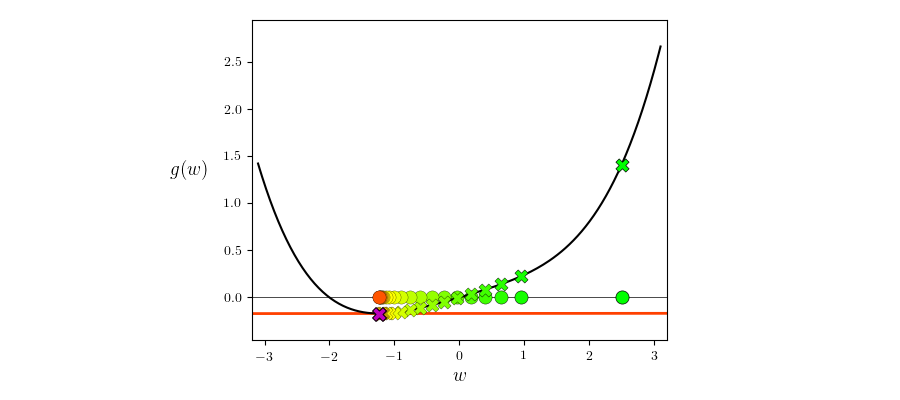
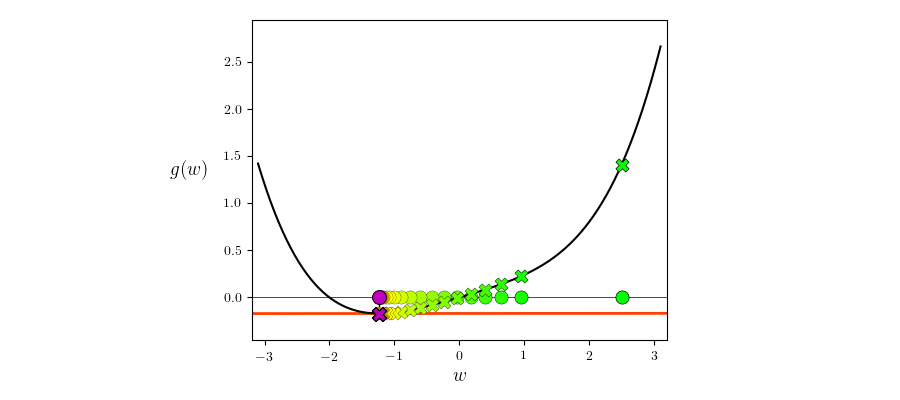
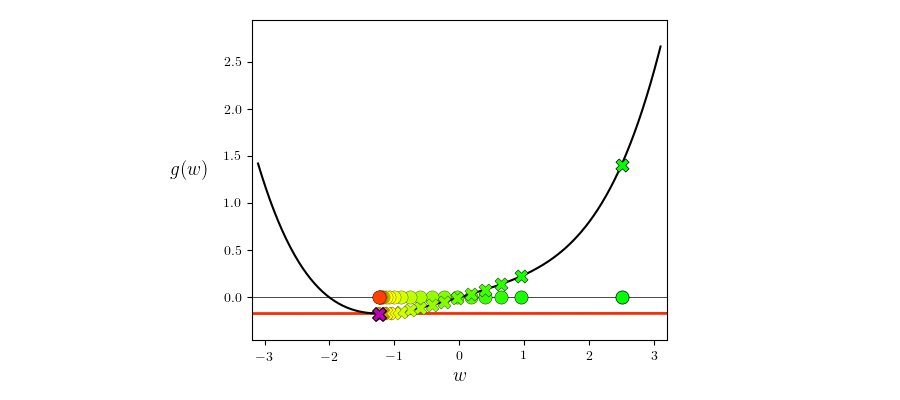
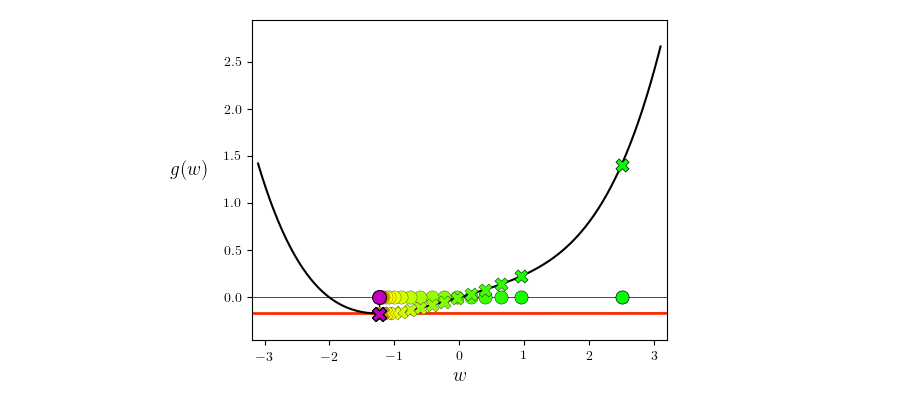
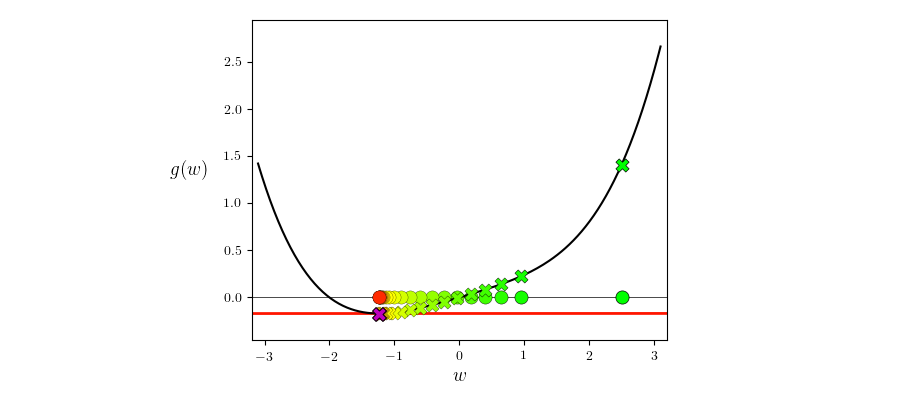
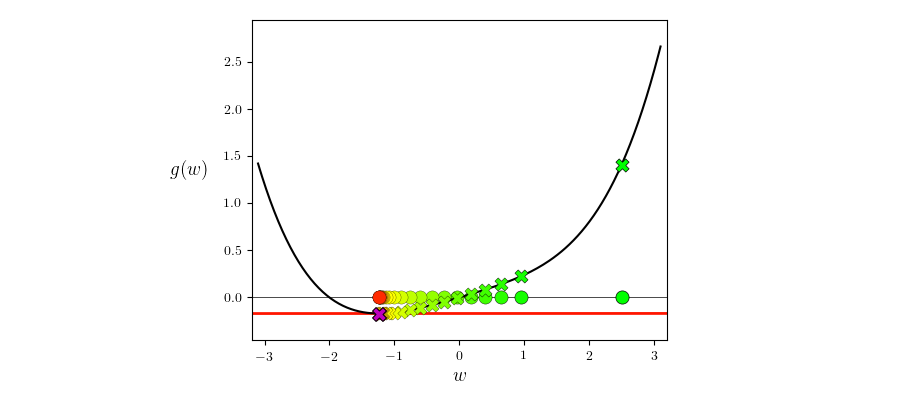
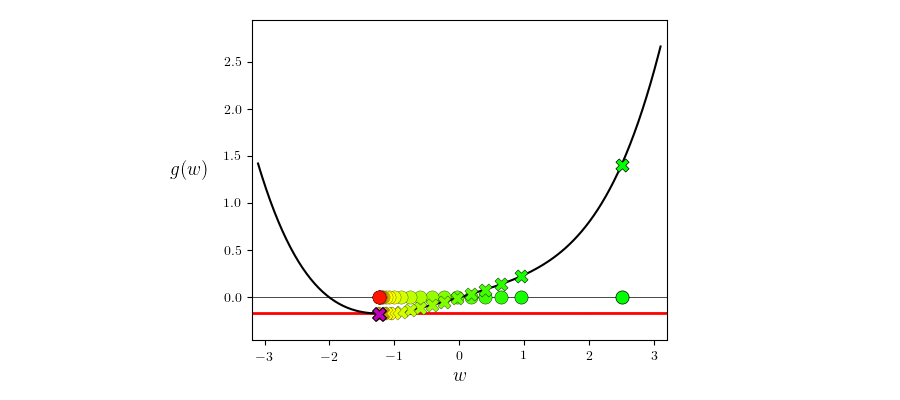
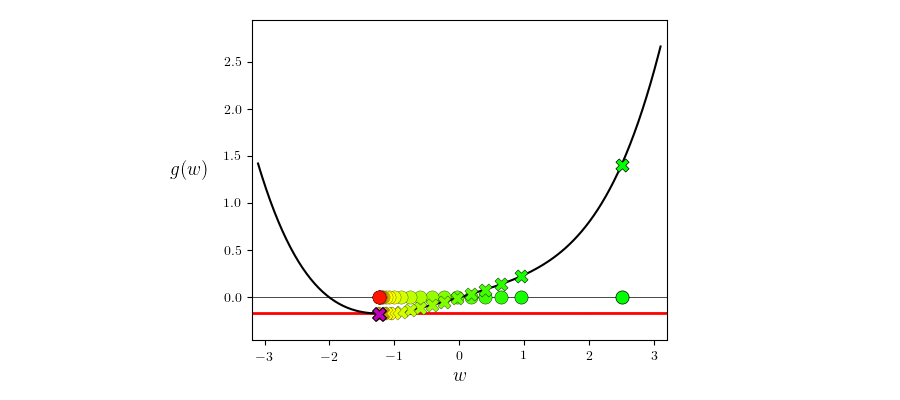
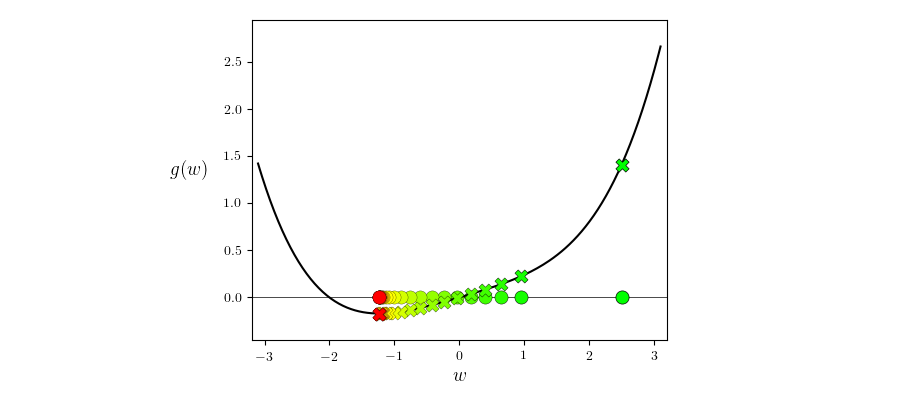

In [15]:
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)

# run gradient descent 
w = 2.5; alpha = 1; max_its = 25;
weight_history,cost_history = gradient_descent(g,alpha,max_its,w)

# animate run
anime_plotter.gradient_descent(g,weight_history)


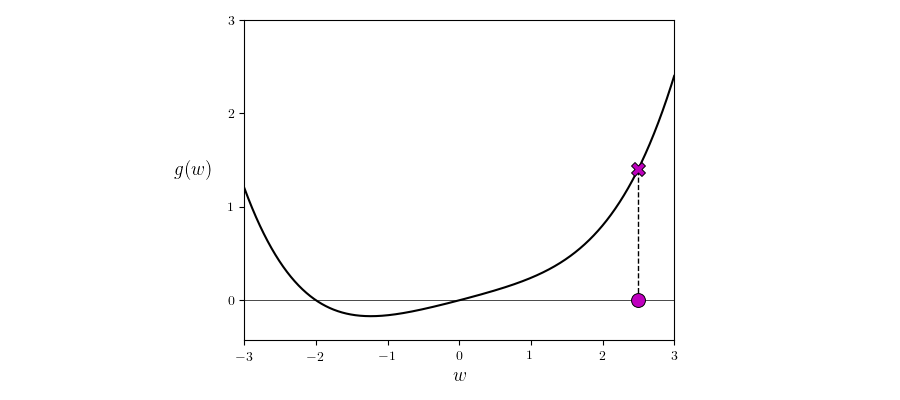
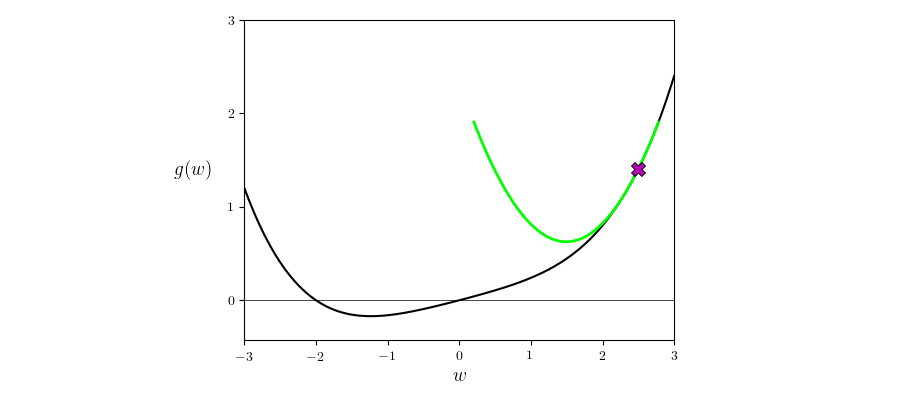
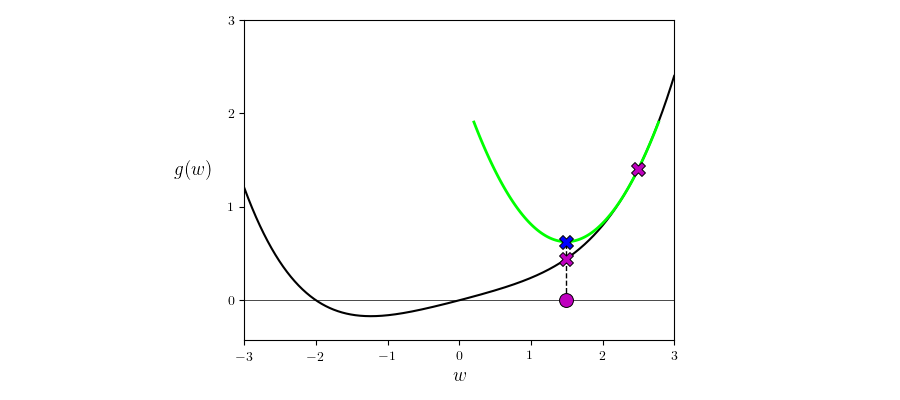
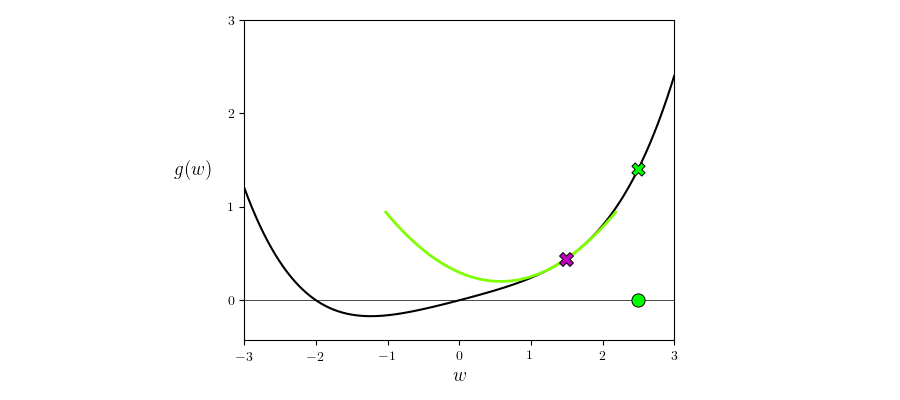
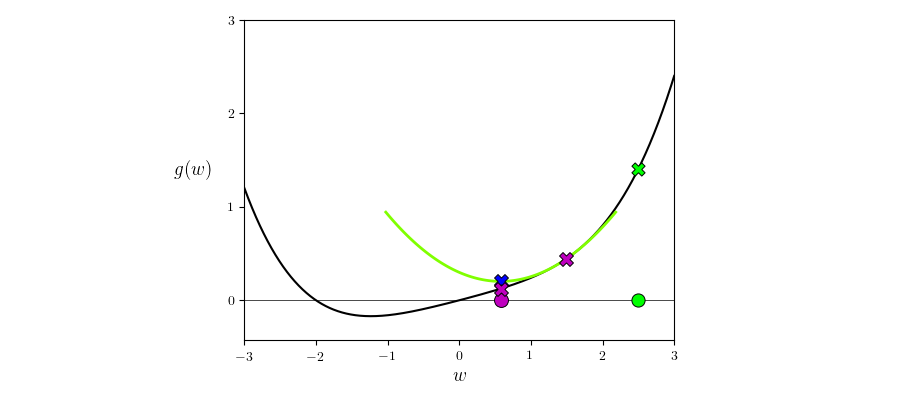
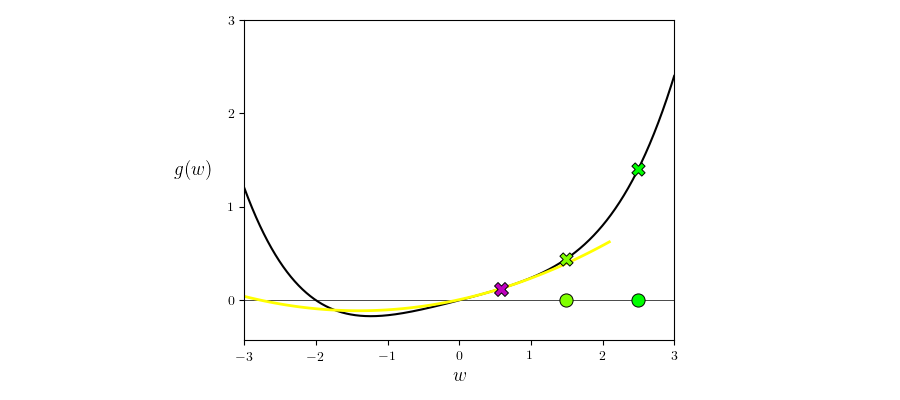
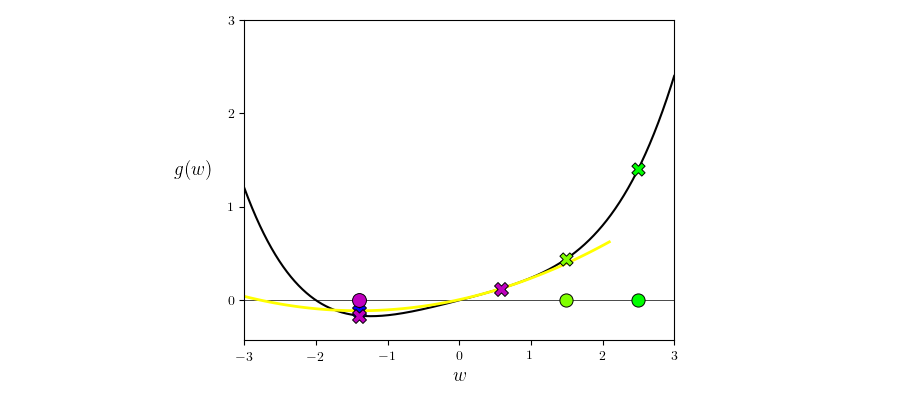
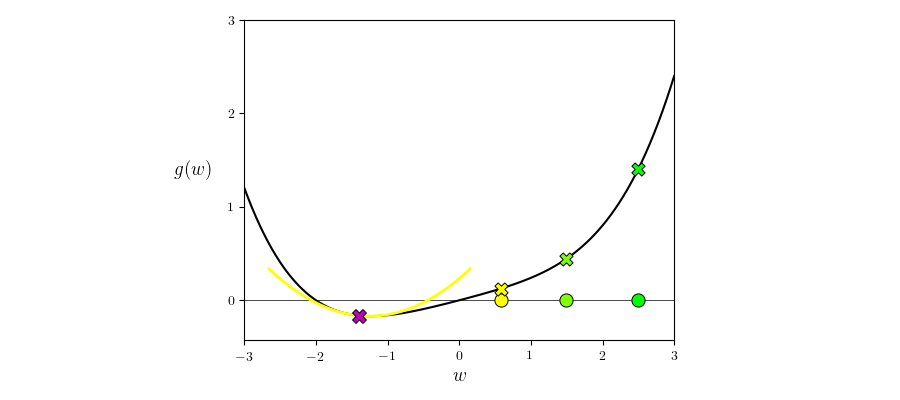
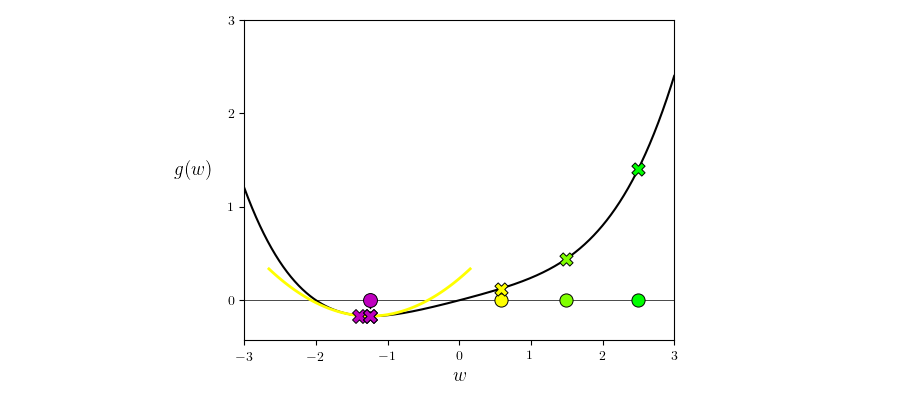
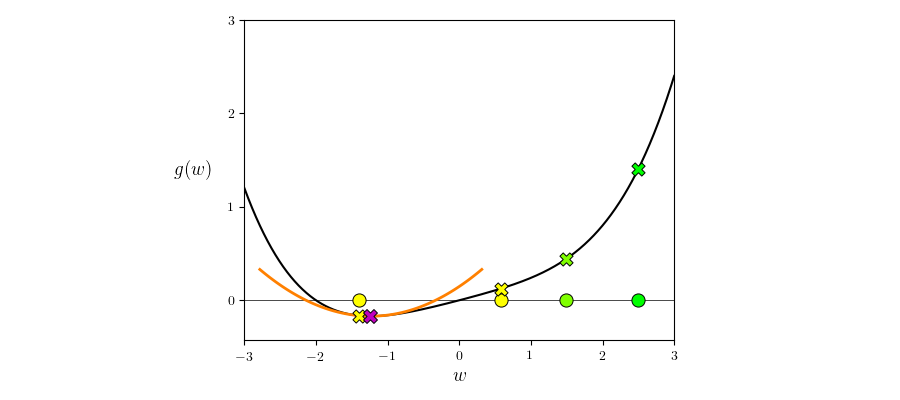
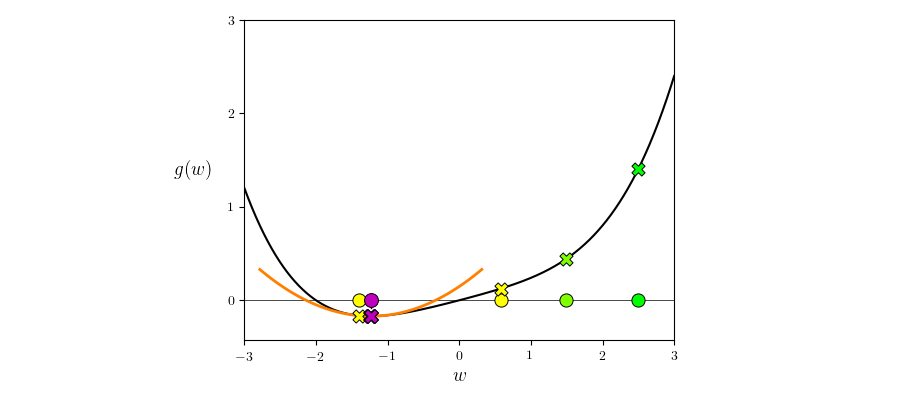
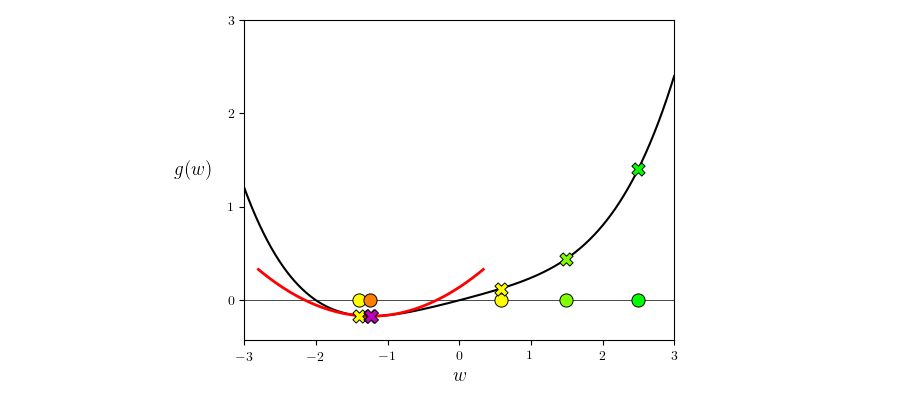
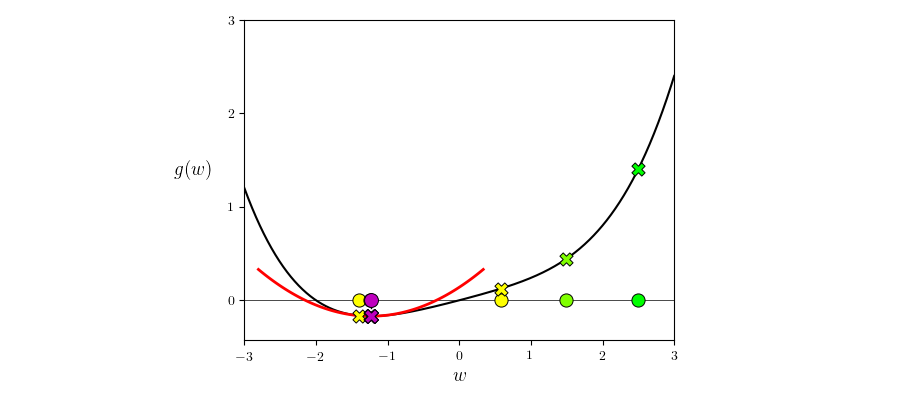
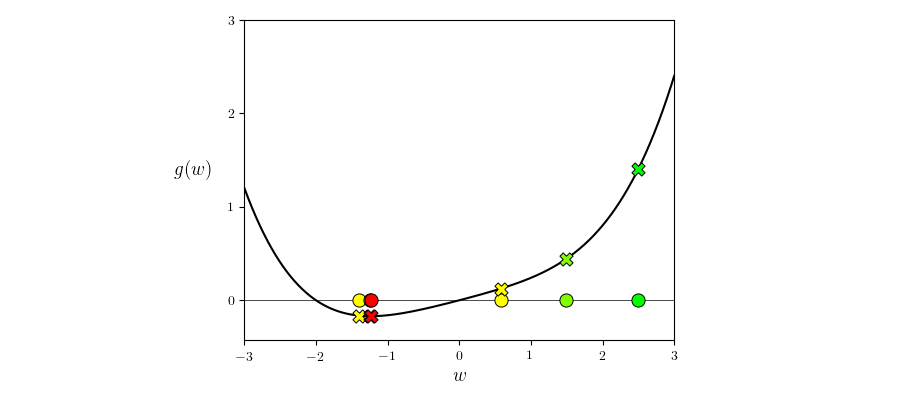

In [84]:
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)

# run gradient descent 
w = 2.5; max_its = 5;
weight_history,cost_history = newtons_method(g,max_its,w)

# animate the process
anime_plotter.newtons_method(g,weight_history)

# 2d static plots - double panel

<IPython.core.display.Javascript object>


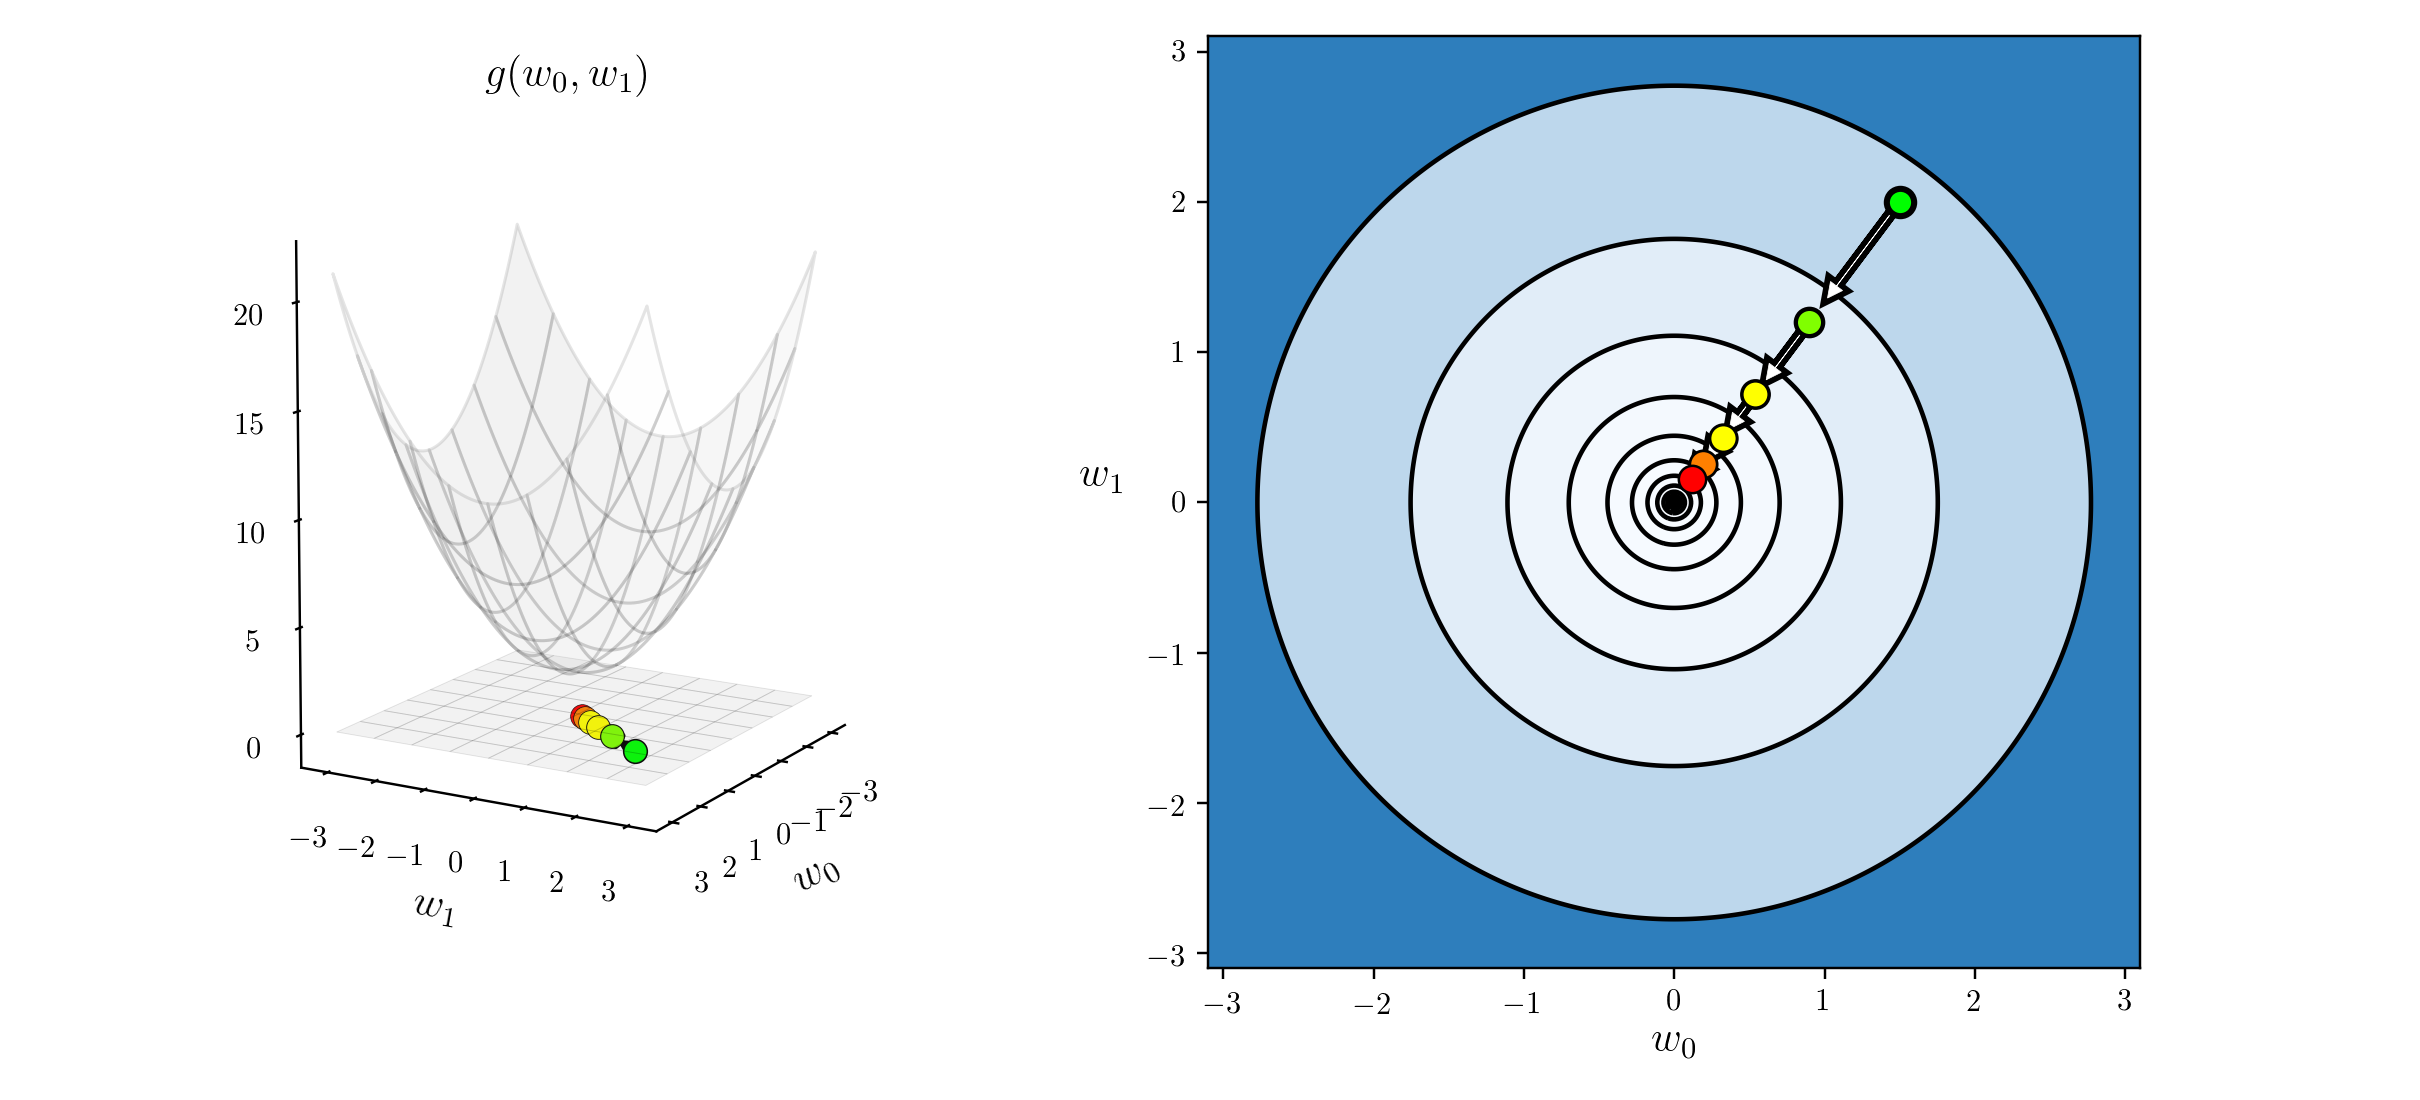

In [85]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.dot(w.T,w) + 2

# run gradient descent 
w = np.array([1.5,2]); max_its = 5; alpha = 0.2;
weight_history,cost_history = gradient_descent(g,alpha,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_surface_contour_plot(g,weight_history,view = [10,30])

<IPython.core.display.Javascript object>


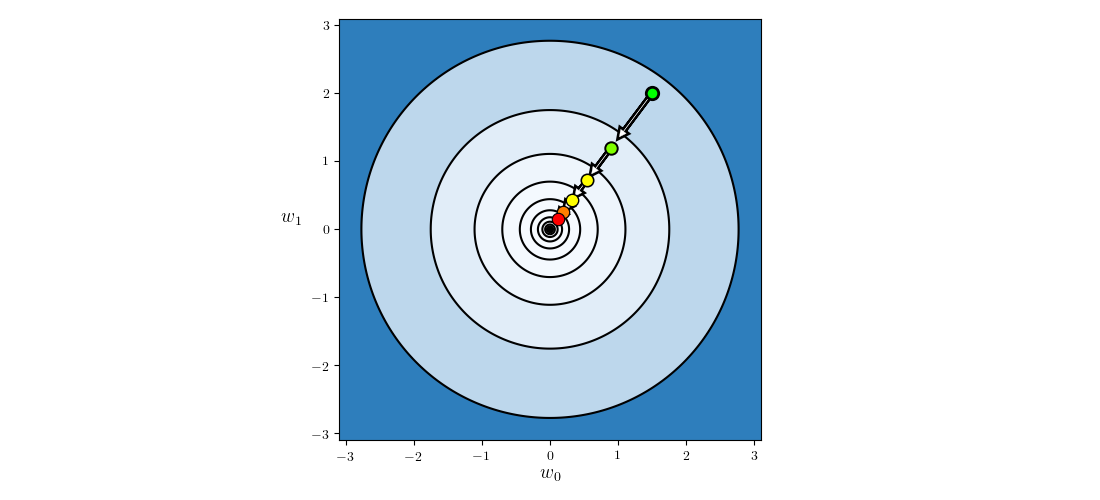

In [3]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.dot(w.T,w) + 2

# run gradient descent 
w = np.array([1.5,2]); max_its = 5; alpha = 0.2;
weight_history,cost_history = gradient_descent(g,alpha,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_contour_plot(g,weight_history)